# Introduction
In healthcare systems around the world, missed appointments is a significant operational and financial burden. Missed appointments can lead to longer wait times, inefficient scheduling, and poorer patient outcomes; therefore, resulting in an increase in costs and reduce accessibility for others needing care. An important factor is exploring how appointment scheduling behaviors, such as booking same-day appointments versus those planned far in advance—affect appointment outcomes. Also how day-of-week patterns, lead time, and patient demographics may hold valuable insights into patient reliability and clinic performance.

## Problem Statement
How can we use historical clinical scheduling data to understand and predict what patients are likely to miss their medical appointments?

What are we aiming for:
* Uncovering patient behavorial patterns related to No-Shows, attendance, etc.
* Examine factors such as Lead-Time, Day of Week, Patient History, etc.
* Develop classification models that predict appointment attendance.
* Create business-actionable insights in lowering No-Show rates

## Data Overview
Dataset consists of over 110,000 patients at a Brazil clinical setting.

## Goal of Analysis
This analysis combines Exploratory Data Analysis (EDA) with predictive modeling to:
* Discovring key variables driving missed appointments
* Build and evaluate Logistic Regression and Random Forest models in predicting no-shows
* Recommend operational changes for high-risk patients.

* pydoc is for using SQLite in Python
* Pandas, matlab, and numpy are used for the data cleaning

In [2]:
import pydoc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Data Cleaning

Before performing EDA and building predictive models, the dataset required preprocessing to ensure accuracy, consistency, and usability. Below are the key data cleaning steps:

In [38]:
#Importing Dataset & Making a Copy
project1 = pd.read_csv('KaggleV2-May-2016.csv')
project_copy = project1.copy()

### Additional information regarding cities and states of Brazil was created and merged to original dataset.

In [40]:
#Importing City/State CSV file
city_state = pd.read_csv ("Brazil's City_State spreadsheet - Sheet1.csv")
city_copy = city_state.copy()

In [42]:
#Checking first five elements
city_copy.head()

,Neighbourhood,City,State
0,jardim da penha,Vitória,Espirito Santo
1,mata da praia,Vitória,Espirito Santo
2,pontal de camburi,Vitória,Espirito Santo
3,república,Vitória,Espirito Santo
4,goiabeiras,Vitória,Espirito Santo


### Viewing Both Datasets; No missing values were found.

In [44]:
#Getting info on data set just to make sure import has correct info
city_copy.info()#Getting dataset info like dtype

city_copy.describe()#Checking description of dataset

city_copy.isnull().sum() #Checking to see if there are any missingness

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Neighbourhood  81 non-null     object
 1   City           81 non-null     object
 2   State          81 non-null     object
dtypes: object(3)
memory usage: 2.0+ KB


Neighbourhood    0
City             0
State            0
dtype: int64

In [46]:
project_copy.head()
project_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 16 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   PatientId                  110527 non-null  float64
 1   AppointmentID              110527 non-null  int64  
 2   Gender                     110527 non-null  object 
 3   ScheduledDay               110527 non-null  object 
 4   AppointmentDay             110527 non-null  object 
 5   Age                        110527 non-null  int64  
 6   Neighbourhood              110527 non-null  object 
 7   Scholarship                110527 non-null  int64  
 8   Hipertension               110527 non-null  int64  
 9   Diabetes                   110527 non-null  int64  
 10  Alcoholism                 110527 non-null  int64  
 11  Handcap                    110527 non-null  int64  
 12  SMS_received               110527 non-null  int64  
 13  No-show                    11

### Part of data cleaning is converting Date columns to Datetime Format, then we normalized the time to 00:00:00. This allows us our TimeDiff variable in resulting in any results less than 0. Additional variables 'ScheduledDOW', 'AppointmentDOW', and 'Days In Advance' were created. Variables Scheduled Day & Appointment Day format were changed to yyy/mm/dd. In making sure the dates within the dataset made sense, we deleted appointment dates that were before scheduled dates.

In [48]:
#Always Convert to datetime
project_copy['ScheduledDay'] = pd.to_datetime(project_copy['ScheduledDay'])
project_copy['AppointmentDay'] = pd.to_datetime(project_copy['AppointmentDay'])

# Normalizing to set time as 00:00:00 - Avoiding - Days in Advance
project_copy['ScheduledDay'] = project_copy['ScheduledDay'].dt.normalize()
project_copy['AppointmentDay'] = project_copy['AppointmentDay'].dt.normalize()

#Creating Weekday Variable from Appointment Day
project_copy['WeekDay_Appointment'] = project_copy['AppointmentDay'].dt.isocalendar().day

project_copy['ScheduledDOW'] = project_copy['ScheduledDay'].dt.day_name() #Gets the day appt was scheduled

project_copy['AppointmentDOW'] = project_copy['AppointmentDay'].dt.day_name() #Gets the day appt was scheduled


#Appointment Days from Scheduled Days
project_copy['Days_In_Advanced'] = (project_copy['AppointmentDay'] - project_copy['ScheduledDay']).dt.days

#Changing ScheduledDay and AppointmentDay to onlyu yyyy/mm/dd (Getting rid of time)
project_copy['ScheduledDay'] = pd.to_datetime(project_copy['ScheduledDay']).dt.date
project_copy['AppointmentDay'] = pd.to_datetime(project_copy['AppointmentDay']).dt.date

#Making sure the code ran correctly
project_copy.head()
project_copy

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Zip Code,Quality of Transportation,WeekDay_Appointment,ScheduledDOW,AppointmentDOW,Days_In_Advanced
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,NaN,NaN,5,Friday,Friday,0
1,5.589980e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,NaN,NaN,5,Friday,Friday,0
2,4.262960e+12,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,NaN,NaN,5,Friday,Friday,0
3,8.679510e+11,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,NaN,NaN,5,Friday,Friday,0
4,8.841190e+12,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,NaN,NaN,5,Friday,Friday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2.572130e+12,5651768,F,2016-05-03,2016-06-07,56,MARIA ORTIZ,0,0,0,0,0,1,No,NaN,NaN,2,Tuesday,Tuesday,35
110523,3.596270e+12,5650093,F,2016-05-03,2016-06-07,51,MARIA ORTIZ,0,0,0,0,0,1,No,NaN,NaN,2,Tuesday,Tuesday,35
110524,1.557660e+13,5630692,F,2016-04-27,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,No,NaN,NaN,2,Wednesday,Tuesday,41
110525,9.213490e+13,5630323,F,2016-04-27,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,No,NaN,NaN,2,Wednesday,Tuesday,41


In [50]:
#Checking for if Scheduled or Appointment Dates Make Sense
invalid_dates = project_copy[project_copy['AppointmentDay'] < project_copy['ScheduledDay']]
print(invalid_dates)

#Since it is only 5 rows affected, we will delete them
project_copy = project_copy[project_copy['AppointmentDay'] >= project_copy['ScheduledDay']]

          PatientId  AppointmentID Gender ScheduledDay AppointmentDay  Age  \
27033  7.839270e+12        5679978      M   2016-05-10     2016-05-09   38   
55226  7.896290e+12        5715660      F   2016-05-18     2016-05-17   19   
64175  2.425230e+13        5664962      F   2016-05-05     2016-05-04   22   
71533  9.982320e+14        5686628      F   2016-05-11     2016-05-05   81   
72362  3.787480e+12        5655637      M   2016-05-04     2016-05-03    7   

       Neighbourhood  Scholarship  Hipertension  Diabetes  Alcoholism  \
27033    RESISTÊNCIA            0             0         0           0   
55226  SANTO ANTÔNIO            0             0         0           0   
64175     CONSOLAÇÃO            0             0         0           0   
71533  SANTO ANTÔNIO            0             0         0           0   
72362     TABUAZEIRO            0             0         0           0   

       Handcap  SMS_received No-show  Zip Code  Quality of Transportation  \
27033        1 

In [52]:
#Deleting Quality_transportation for project_copy
del project_copy['Quality of Transportation']

In [54]:
print(f"Number of invalid date rows: {len(invalid_dates)}")
print(f"Percentage: {len(invalid_dates)/len(project_copy)*100:.4f}%")

Number of invalid date rows: 5
Percentage: 0.0045%


### Checking for Duplicated IDs

In [56]:
#Checking for Duplicate IDs
project_copy['AppointmentID'].duplicated().sum()

#PatientId has Duplicates Due to Patients Revisiting Clinic

0

### Correcting Column Names

In [58]:
#Correcting Column Names
project_copy.columns

project_copy.rename(columns={'Hipertension': 'Hypertension', 'Handcap':'Handicap', 'No-show':'No_show', 'Zip Code': 'Zip_code', 'Quality of Transportation': 'Quality_transportation'}, inplace=True)



C:\Users\ajame\AppData\Local\Temp\ipykernel_14576\1872670963.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  project_copy.rename(columns={'Hipertension': 'Hypertension', 'Handcap':'Handicap', 'No-show':'No_show', 'Zip Code': 'Zip_code', 'Quality of Transportation': 'Quality_transportation'}, inplace=True)


### Checking Uniqueness in Categorical Variables

In [60]:
#Checking Uniqueness in Categorical Variables
project_copy['Neighbourhood'].unique()

project_copy['Neighbourhood'] = project_copy['Neighbourhood'].str.lower().str.strip()
project_copy['Neighbourhood'].unique()

C:\Users\ajame\AppData\Local\Temp\ipykernel_14576\3661851377.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  project_copy['Neighbourhood'] = project_copy['Neighbourhood'].str.lower().str.strip()


array(['jardim da penha', 'mata da praia', 'pontal de camburi',
       'república', 'goiabeiras', 'andorinhas', 'conquista',
       'nova palestina', 'da penha', 'tabuazeiro', 'bento ferreira',
       'são pedro', 'santa martha', 'são cristóvão', 'maruípe',
       'grande vitória', 'são benedito', 'ilha das caieiras',
       'santo andré', 'solon borges', 'bonfim', 'jardim camburi',
       'maria ortiz', 'jabour', 'antônio honório', 'resistência',
       'ilha de santa maria', 'jucutuquara', 'monte belo',
       'mário cypreste', 'santo antônio', 'bela vista', 'praia do suá',
       'santa helena', 'itararé', 'inhanguetá', 'universitário',
       'são josé', 'redenção', 'santa clara', 'centro', 'parque moscoso',
       'do moscoso', 'santos dumont', 'caratoíra', 'ariovaldo favalessa',
       'ilha do frade', 'gurigica', 'joana d´arc', 'consolação',
       'praia do canto', 'boa vista', 'morada de camburi', 'santa luíza',
       'santa lúcia', 'barro vermelho', 'estrelinha', 'forte são 

### Eliminating trailing spaces for the city_copy dataset

In [62]:
#Eliminating trailing spaces for the city_copy dataset
city_copy["Neighbourhood"] = city_copy["Neighbourhood"].str.strip()
city_copy["Neighbourhood"].unique()

array(['jardim da penha', 'mata da praia', 'pontal de camburi',
       'república', 'goiabeiras', 'andorinhas', 'conquista',
       'nova palestina', 'da penha', 'tabuazeiro', 'bento ferreira',
       'são pedro', 'santa martha', 'são cristóvão', 'maruípe',
       'grande vitória', 'são benedito', 'ilha das caieiras',
       'santo andré', 'solon borges', 'bonfim', 'jardim camburi',
       'maria ortiz', 'jabour', 'antônio honório', 'resistência',
       'ilha de santa maria', 'jucutuquara', 'monte belo',
       'mário cypreste', 'santo antônio', 'bela vista', 'praia do suá',
       'santa helena', 'itararé', 'inhanguetá', 'universitário',
       'são josé', 'redenção', 'santa clara', 'centro', 'parque moscoso',
       'do moscoso', 'santos dumont', 'caratoíra', 'ariovaldo favalessa',
       'ilha do frade', 'gurigica', 'joana d´arc', 'consolação',
       'praia do canto', 'boa vista', 'morada de camburi', 'santa luíza',
       'santa lúcia', 'barro vermelho', 'estrelinha', 'forte são 

In [64]:
#Checking the Count by Neighbourhood
neighborhood_count = project_copy['Neighbourhood'].value_counts().sort_index()

### Correcting the Values of Age and Handicap, making the values have more sense

In [68]:
#Correcting Age & Handicap
project_copy.describe()

project_copy.loc[project_copy['Age'] <= 0, 'Age'] = 1
project_copy.loc[project_copy['Handicap'] >= 2, 'Handicap'] = 1

project_copy.describe()

,PatientId,AppointmentID,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,Zip_code,WeekDay_Appointment,Days_In_Advanced
count,1.105220e+05,1.105220e+05,110522.00000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,0.0,110522.0,110522.000000
mean,1.474935e+14,5.675305e+06,37.12108,0.098270,0.197255,0.071868,0.030401,0.020258,0.321040,NaN,2.858264,10.184253
std,2.560866e+14,7.129722e+04,23.05926,0.297681,0.397928,0.258270,0.171689,0.140884,0.466878,NaN,1.371683,15.255115
min,3.920000e+04,5.030230e+06,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.0,0.000000
25%,4.172538e+12,5.640284e+06,18.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.0,0.000000
50%,3.173700e+13,5.680574e+06,37.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,3.0,4.000000
75%,9.439275e+13,5.725525e+06,55.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,4.0,15.000000
max,9.999820e+14,5.790484e+06,115.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,6.0,179.000000


In [70]:
project_copy['Age'].value_counts().sort_index()

Age
1      5813
2      1618
3      1513
4      1299
5      1489
       ... 
98        6
99        1
100       4
102       2
115       5
Name: count, Length: 102, dtype: int64

### Removing Outliers of patients who are 115

In [74]:
#Removing Outliers of 115
project_copy = project_copy[project_copy['Age'] != 115]

In [76]:
project_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110517 entries, 0 to 110526
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   PatientId            110517 non-null  float64
 1   AppointmentID        110517 non-null  int64  
 2   Gender               110517 non-null  object 
 3   ScheduledDay         110517 non-null  object 
 4   AppointmentDay       110517 non-null  object 
 5   Age                  110517 non-null  int64  
 6   Neighbourhood        110517 non-null  object 
 7   Scholarship          110517 non-null  int64  
 8   Hypertension         110517 non-null  int64  
 9   Diabetes             110517 non-null  int64  
 10  Alcoholism           110517 non-null  int64  
 11  Handicap             110517 non-null  int64  
 12  SMS_received         110517 non-null  int64  
 13  No_show              110517 non-null  object 
 14  Zip_code             0 non-null       float64
 15  WeekDay_Appointment  1

In [78]:
project_copy['No_show'].value_counts()

No_show
No     88206
Yes    22311
Name: count, dtype: int64

### Removing PatientID and AppointmentID

In [80]:
#Removing PatientID and AppointmentID

project_copy.drop(['PatientId', 'AppointmentID'], axis=1, inplace=True)

#Checking to make sure PatientId and AppointmenID
project_copy.head()

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show,Zip_code,WeekDay_Appointment,ScheduledDOW,AppointmentDOW,Days_In_Advanced
0,F,2016-04-29,2016-04-29,62,jardim da penha,0,1,0,0,0,0,No,NaN,5,Friday,Friday,0
1,M,2016-04-29,2016-04-29,56,jardim da penha,0,0,0,0,0,0,No,NaN,5,Friday,Friday,0
2,F,2016-04-29,2016-04-29,62,mata da praia,0,0,0,0,0,0,No,NaN,5,Friday,Friday,0
3,F,2016-04-29,2016-04-29,8,pontal de camburi,0,0,0,0,0,0,No,NaN,5,Friday,Friday,0
4,F,2016-04-29,2016-04-29,56,jardim da penha,0,1,1,0,0,0,No,NaN,5,Friday,Friday,0


### Using SQLite3, we are creating a database in establishing Zip Codes for each area

In [82]:
#Creating a database to change vals of Zip_Code
import sqlite3
conn = sqlite3.connect('project_copy.db')
project_copy.to_sql('appointments', conn, if_exists='replace', index = False)

cursor = conn.cursor()

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29060-000
Where TRIM(Neighbourhood) = 'jardim da penha';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29066-000
Where TRIM(Neighbourhood) = 'mata da praia';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29075-000
Where TRIM(Neighbourhood) = 'pontal de camburi';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29070-000
WHERE TRIM(Neighbourhood) = 'república';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29075-000
WHERE TRIM(Neighbourhood) = 'goiabeiras';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29047-000
WHERE TRIM(Neighbourhood) = 'andorinhas';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29032-000
WHERE TRIM(Neighbourhood) = 'conquista';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29032-000
WHERE TRIM(Neighbourhood) = 'nova palestina';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29045-000
WHERE TRIM(Neighbourhood) = 'da penha';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29043-000
WHERE TRIM(Neighbourhood) = 'tabuazeiro';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29050-000
WHERE TRIM(Neighbourhood) = 'bento ferreira';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29030-000
WHERE TRIM(Neighbourhood) = 'são pedro';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29027-000
WHERE TRIM(Neighbourhood) = 'santa martha';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29047-000
WHERE TRIM(Neighbourhood) = 'são cristóvão';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29045-000
WHERE TRIM(Neighbourhood) = 'maruípe';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29000-000
WHERE TRIM(Neighbourhood) = 'grande vitória';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29047-000
WHERE TRIM(Neighbourhood) = 'são benedito';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29031-000
WHERE TRIM(Neighbourhood) = 'ilha das caieiras';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29032-000
WHERE TRIM(Neighbourhood) = 'santo andré';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29047-000
WHERE TRIM(Neighbourhood) = 'solon borges';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29047-000
WHERE TRIM(Neighbourhood) = 'bonfim';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29090-000
WHERE TRIM(Neighbourhood) = 'jardim camburi';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29075-000
WHERE TRIM(Neighbourhood) = 'maria ortiz';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29075-000
WHERE TRIM(Neighbourhood) = 'jabour';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29075-000
WHERE TRIM(Neighbourhood) = 'antônio honório';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29027-000
WHERE TRIM(Neighbourhood) = 'resistência';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29051-000
WHERE TRIM(Neighbourhood) = 'ilha de santa maria';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29040-000
WHERE TRIM(Neighbourhood) = 'jucutuquara';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29053-000
WHERE TRIM(Neighbourhood) = 'monte belo';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29040-000
WHERE TRIM(Neighbourhood) = 'mário cypreste';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29032-000
WHERE TRIM(Neighbourhood) = 'santo antônio';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29032-000
WHERE TRIM(Neighbourhood) = 'bela vista';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29052-000
WHERE TRIM(Neighbourhood) = 'praia do suá';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29056-000
WHERE TRIM(Neighbourhood) = 'santa helena';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29047-000
WHERE TRIM(Neighbourhood) = 'itararé';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29027-000
WHERE TRIM(Neighbourhood) = 'inhanguetá';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29040-000
WHERE TRIM(Neighbourhood) = 'universitário';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29032-000
WHERE TRIM(Neighbourhood) = 'são josé';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29027-000
WHERE TRIM(Neighbourhood) = 'redenção';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29025-000
WHERE TRIM(Neighbourhood) = 'santa clara';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29010-000
WHERE TRIM(Neighbourhood) = 'centro';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29015-000
WHERE TRIM(Neighbourhood) = 'parque moscoso';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29015-000
WHERE TRIM(Neighbourhood) = 'do moscoso';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 36240-000
WHERE TRIM(Neighbourhood) = 'santos dumont';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29027-000
WHERE TRIM(Neighbourhood) = 'caratoíra';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29032-000
WHERE TRIM(Neighbourhood) = 'ariovaldo favalessa';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29052-000
WHERE TRIM(Neighbourhood) = 'ilha do frade';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29045-000
WHERE TRIM(Neighbourhood) = 'gurigica';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29047-000
WHERE TRIM(Neighbourhood) = 'joana d´arc';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29045-000
WHERE TRIM(Neighbourhood) = 'consolação';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29055-000
WHERE TRIM(Neighbourhood) = 'praia do canto';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29032-000
WHERE TRIM(Neighbourhood) = 'boa vista';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29090-000
WHERE TRIM(Neighbourhood) = 'morada de camburi';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29056-000
WHERE TRIM(Neighbourhood) = 'santa luíza';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29056-000
WHERE TRIM(Neighbourhood) = 'santa lúcia';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29056-000
WHERE TRIM(Neighbourhood) = 'barro vermelho';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29027-000
WHERE TRIM(Neighbourhood) = 'estrelinha';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29015-000
WHERE TRIM(Neighbourhood) = 'forte são joão';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29015-000
WHERE TRIM(Neighbourhood) = 'fonte grande';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29052-000
WHERE TRIM(Neighbourhood) = 'enseada do suá';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29032-000
WHERE TRIM(Neighbourhood) = 'santos reis';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29015-000
WHERE TRIM(Neighbourhood) = 'piedade';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29051-000
WHERE TRIM(Neighbourhood) = 'jesus de nazareth';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29015-000
WHERE TRIM(Neighbourhood) = 'santa tereza';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29045-000
WHERE TRIM(Neighbourhood) = 'cruzamento';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29025-000
WHERE TRIM(Neighbourhood) = 'ilha do príncipe';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29027-000
WHERE TRIM(Neighbourhood) = 'romão';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29032-000
WHERE TRIM(Neighbourhood) = 'comdusa';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29047-000
WHERE TRIM(Neighbourhood) = 'santa cecília';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29015-000
WHERE TRIM(Neighbourhood) = 'vila rubim';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29040-000
WHERE TRIM(Neighbourhood) = 'de lourdes';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29015-000
WHERE TRIM(Neighbourhood) = 'do quadro';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29015-000
WHERE TRIM(Neighbourhood) = 'do cabral';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29045-000
WHERE TRIM(Neighbourhood) = 'horto';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29075-000
WHERE TRIM(Neighbourhood) = 'segurança do lar';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29052-000
WHERE TRIM(Neighbourhood) = 'ilha do boi';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29045-000
WHERE TRIM(Neighbourhood) = 'fradinhos';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29051-000
WHERE TRIM(Neighbourhood) = 'nazareth';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29075-000
WHERE TRIM(Neighbourhood) = 'aeroporto';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29000-000
WHERE TRIM(Neighbourhood) = 'ilhas oceânicas de trindade';
""")

cursor.execute("""
UPDATE appointments
SET Zip_Code = 29090-000
WHERE TRIM(Neighbourhood) = 'parque industrial';
""")



In [84]:
#Checking to make sure code implemented correctly
project_copy_update = pd.read_sql_query('SELECT * FROM appointments WHERE Zip_Code = 29060', conn)
print(project_copy_update.head())

  Gender ScheduledDay AppointmentDay  Age    Neighbourhood  Scholarship  \
0      F   2016-04-29     2016-04-29   62  jardim da penha            0   
1      M   2016-04-29     2016-04-29   56  jardim da penha            0   
2      F   2016-04-29     2016-04-29   56  jardim da penha            0   
3      F   2016-04-06     2016-04-29   69  jardim da penha            0   
4      M   2016-04-29     2016-04-29   56  jardim da penha            0   

   Hypertension  Diabetes  Alcoholism  Handicap  SMS_received No_show  \
0             1         0           0         0             0      No   
1             0         0           0         0             0      No   
2             1         1           0         0             0      No   
3             1         0           0         0             1      No   
4             0         0           0         0             0      No   

   Zip_code  WeekDay_Appointment ScheduledDOW AppointmentDOW  Days_In_Advanced  
0   29060.0                  

In [86]:
cursor.execute("""
SELECT
  Zip_Code
FROM appointments
WHERE Zip_Code IS NULL
""")

rows = cursor.fetchall()
print(rows)

[]


### Using SQLite3, adding Neighbourhood Class

In [88]:
#Adding Neighbourhood_Class
cursor.execute("""
ALTER TABLE appointments
ADD Neighbourhood_Class
""")

cursor.execute("""
UPDATE appointments
SET Neighbourhood_Class = 'Poor'
WHERE TRIM(Neighbourhood) IN ('fradinhos','jesus de nazareth','itararé','são benedito','da penha','andorinhas', 'conquista', 'nova palestina', 'são pedro', 'santo andré', 'resistência',
  'ilha das caieiras', 'bela vista', 'redenção', 'inhanguetá', 'santos reis', 'santa clara',
  'caratoíra', 'romão', 'comdusa', 'estrelinha', 'nazareth', 'piedade', 'do cabral',
  'do quadro', 'parque moscoso', 'do moscoso');
""")

cursor.execute("""
UPDATE appointments
SET Neighbourhood_Class = 'Middle Class'
WHERE TRIM(Neighbourhood) IN ('santos dumont','santo antônio','pontal de camburi','jardim da penha','goiabeiras', 'jardim camburi', 'mata da praia', 'tabuazeiro', 'bento ferreira',
  'são cristóvão', 'maruípe', 'santa martha', 'solon borges', 'bonfim', 'maria ortiz',
  'jabour', 'antônio honório', 'monte belo', 'mário cypreste', 'santa tereza', 'universitário',
  'santa cecília', 'boa vista', 'morada de camburi', 'consolação', 'cruzamento', 'de lourdes',
  'ariovaldo favalessa', 'gurigica', 'joana d´arc', 'horto', 'segurança do lar', 'aeroporto',
  'parque industrial', 'são josé');
""")

cursor.execute("""
UPDATE appointments
SET Neighbourhood_Class = 'Wealthy'
WHERE TRIM(Neighbourhood) IN ('ilhas oceânicas de trindade','grande vitória','praia do canto', 'enseada do suá', 'ilha do boi', 'ilha do frade', 'santa lúcia',
  'santa luíza', 'santa helena', 'barro vermelho', 'praia do suá', 'república',
  'centro', 'jucutuquara', 'forte são joão', 'fonte grande', 'vila rubim',
  'ilha de santa maria', 'ilha do príncipe');
""")

In [90]:
project_copy_update = pd.read_sql_query("SELECT * FROM appointments", conn)
print(project_copy_update)

       Gender ScheduledDay AppointmentDay  Age      Neighbourhood  \
0           F   2016-04-29     2016-04-29   62    jardim da penha   
1           M   2016-04-29     2016-04-29   56    jardim da penha   
2           F   2016-04-29     2016-04-29   62      mata da praia   
3           F   2016-04-29     2016-04-29    8  pontal de camburi   
4           F   2016-04-29     2016-04-29   56    jardim da penha   
...       ...          ...            ...  ...                ...   
110512      F   2016-05-03     2016-06-07   56        maria ortiz   
110513      F   2016-05-03     2016-06-07   51        maria ortiz   
110514      F   2016-04-27     2016-06-07   21        maria ortiz   
110515      F   2016-04-27     2016-06-07   38        maria ortiz   
110516      F   2016-04-27     2016-06-07   54        maria ortiz   

        Scholarship  Hypertension  Diabetes  Alcoholism  Handicap  \
0                 0             1         0           0         0   
1                 0             0

In [92]:
cursor.execute("""
SELECT
  DISTINCT (Neighbourhood)
FROM appointments
WHERE Neighbourhood_Class IS NULL
""")

rows = cursor.fetchall()
print(rows)

[]


### Saving all changes made to the SQL code and closes the connection

In [94]:
#Saving all changes made to the SQL code and closes the connection
conn.commit()
conn.close()

In [96]:
project_copy_update.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110517 entries, 0 to 110516
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Gender               110517 non-null  object 
 1   ScheduledDay         110517 non-null  object 
 2   AppointmentDay       110517 non-null  object 
 3   Age                  110517 non-null  int64  
 4   Neighbourhood        110517 non-null  object 
 5   Scholarship          110517 non-null  int64  
 6   Hypertension         110517 non-null  int64  
 7   Diabetes             110517 non-null  int64  
 8   Alcoholism           110517 non-null  int64  
 9   Handicap             110517 non-null  int64  
 10  SMS_received         110517 non-null  int64  
 11  No_show              110517 non-null  object 
 12  Zip_code             110517 non-null  float64
 13  WeekDay_Appointment  110517 non-null  int64  
 14  ScheduledDOW         110517 non-null  object 
 15  AppointmentDOW   

### Creating Days in Between Variable

In [98]:
#Counting number between Schedule Day and appt day
#First have to convert apptday and scheduledday to datetime format

project_copy_update['ScheduledDay'] = pd.to_datetime(project_copy_update['ScheduledDay'])
project_copy_update ['AppointmentDay'] = pd.to_datetime(project_copy_update['AppointmentDay'])

#Subtracting the apptday and scheduledday to get the days between

project_copy_update["Days_Btwn"] = project_copy_update['AppointmentDay'] - project_copy_update['ScheduledDay']

project_copy_update.head()

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show,Zip_code,WeekDay_Appointment,ScheduledDOW,AppointmentDOW,Days_In_Advanced,Neighbourhood_Class,Days_Btwn
0,F,2016-04-29,2016-04-29,62,jardim da penha,0,1,0,0,0,0,No,29060.0,5,Friday,Friday,0,Middle Class,0 days
1,M,2016-04-29,2016-04-29,56,jardim da penha,0,0,0,0,0,0,No,29060.0,5,Friday,Friday,0,Middle Class,0 days
2,F,2016-04-29,2016-04-29,62,mata da praia,0,0,0,0,0,0,No,29066.0,5,Friday,Friday,0,Middle Class,0 days
3,F,2016-04-29,2016-04-29,8,pontal de camburi,0,0,0,0,0,0,No,29075.0,5,Friday,Friday,0,Middle Class,0 days
4,F,2016-04-29,2016-04-29,56,jardim da penha,0,1,1,0,0,0,No,29060.0,5,Friday,Friday,0,Middle Class,0 days


In [100]:
#Moving Days_Btwn to be next to ApptDay
project_copy_update.insert(3, 'Days_Btwn', project_copy_update.pop('Days_Btwn'))
project_copy_update.head()

,Gender,ScheduledDay,AppointmentDay,Days_Btwn,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show,Zip_code,WeekDay_Appointment,ScheduledDOW,AppointmentDOW,Days_In_Advanced,Neighbourhood_Class
0,F,2016-04-29,2016-04-29,0 days,62,jardim da penha,0,1,0,0,0,0,No,29060.0,5,Friday,Friday,0,Middle Class
1,M,2016-04-29,2016-04-29,0 days,56,jardim da penha,0,0,0,0,0,0,No,29060.0,5,Friday,Friday,0,Middle Class
2,F,2016-04-29,2016-04-29,0 days,62,mata da praia,0,0,0,0,0,0,No,29066.0,5,Friday,Friday,0,Middle Class
3,F,2016-04-29,2016-04-29,0 days,8,pontal de camburi,0,0,0,0,0,0,No,29075.0,5,Friday,Friday,0,Middle Class
4,F,2016-04-29,2016-04-29,0 days,56,jardim da penha,0,1,1,0,0,0,No,29060.0,5,Friday,Friday,0,Middle Class


### Changing Zip_Code from numerical to categorical (Most Zip codes in DS are categorical instead of numerical)

In [102]:
#Changing Zip_Code from numerical to categorical
#Most Zip codes in DS are categorical instead of numerical

project_copy_update['Zip_code'] = project_copy_update['Zip_code'].astype(str)

#Making sure data ran correctly
project_copy_update.head()

,Gender,ScheduledDay,AppointmentDay,Days_Btwn,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show,Zip_code,WeekDay_Appointment,ScheduledDOW,AppointmentDOW,Days_In_Advanced,Neighbourhood_Class
0,F,2016-04-29,2016-04-29,0 days,62,jardim da penha,0,1,0,0,0,0,No,29060.0,5,Friday,Friday,0,Middle Class
1,M,2016-04-29,2016-04-29,0 days,56,jardim da penha,0,0,0,0,0,0,No,29060.0,5,Friday,Friday,0,Middle Class
2,F,2016-04-29,2016-04-29,0 days,62,mata da praia,0,0,0,0,0,0,No,29066.0,5,Friday,Friday,0,Middle Class
3,F,2016-04-29,2016-04-29,0 days,8,pontal de camburi,0,0,0,0,0,0,No,29075.0,5,Friday,Friday,0,Middle Class
4,F,2016-04-29,2016-04-29,0 days,56,jardim da penha,0,1,1,0,0,0,No,29060.0,5,Friday,Friday,0,Middle Class


In [104]:
#Checking to see if any Zip codes are missing
project_copy_update.isnull().sum() #No nulls except Quality of Transportation

Gender                 0
ScheduledDay           0
AppointmentDay         0
Days_Btwn              0
Age                    0
Neighbourhood          0
Scholarship            0
Hypertension           0
Diabetes               0
Alcoholism             0
Handicap               0
SMS_received           0
No_show                0
Zip_code               0
WeekDay_Appointment    0
ScheduledDOW           0
AppointmentDOW         0
Days_In_Advanced       0
Neighbourhood_Class    0
dtype: int64

### Removing the decimals away from Zip_code and adds -000

In [106]:
#Removing the decimals away from Zip_code and adds -000
project_copy_update['Zip_code'] = project_copy_update['Zip_code'].str.replace('.0', '-000', regex=False) #Treats value as literal string insted of an expression
project_copy_update.head()

,Gender,ScheduledDay,AppointmentDay,Days_Btwn,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show,Zip_code,WeekDay_Appointment,ScheduledDOW,AppointmentDOW,Days_In_Advanced,Neighbourhood_Class
0,F,2016-04-29,2016-04-29,0 days,62,jardim da penha,0,1,0,0,0,0,No,29060-000,5,Friday,Friday,0,Middle Class
1,M,2016-04-29,2016-04-29,0 days,56,jardim da penha,0,0,0,0,0,0,No,29060-000,5,Friday,Friday,0,Middle Class
2,F,2016-04-29,2016-04-29,0 days,62,mata da praia,0,0,0,0,0,0,No,29066-000,5,Friday,Friday,0,Middle Class
3,F,2016-04-29,2016-04-29,0 days,8,pontal de camburi,0,0,0,0,0,0,No,29075-000,5,Friday,Friday,0,Middle Class
4,F,2016-04-29,2016-04-29,0 days,56,jardim da penha,0,1,1,0,0,0,No,29060-000,5,Friday,Friday,0,Middle Class


project_copy_update.info()

### Merging the city_copy with project_copy_update

In [110]:
#Merging the city_copy with project_copy_update
merge_df = pd.merge(project_copy_update, city_copy, how = "outer", on = "Neighbourhood", indicator = False)
merge_df.head()

,Gender,ScheduledDay,AppointmentDay,Days_Btwn,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,...,SMS_received,No_show,Zip_code,WeekDay_Appointment,ScheduledDOW,AppointmentDOW,Days_In_Advanced,Neighbourhood_Class,City,State
0,F,2016-04-18,2016-05-05,17 days,37,aeroporto,0,0,0,0,...,0,Yes,29075-000,4,Monday,Thursday,17,Middle Class,Vitória,Espirito Santo
1,F,2016-05-02,2016-05-09,7 days,58,aeroporto,0,0,0,0,...,0,No,29075-000,1,Monday,Monday,7,Middle Class,Vitória,Espirito Santo
2,F,2016-05-10,2016-05-12,2 days,58,aeroporto,0,0,0,0,...,0,No,29075-000,4,Tuesday,Thursday,2,Middle Class,Vitória,Espirito Santo
3,M,2016-05-06,2016-05-06,0 days,51,aeroporto,0,0,0,0,...,0,No,29075-000,5,Friday,Friday,0,Middle Class,Vitória,Espirito Santo
4,F,2016-03-03,2016-05-17,75 days,64,aeroporto,0,1,0,0,...,0,No,29075-000,2,Thursday,Tuesday,75,Middle Class,Vitória,Espirito Santo


### Checking for any null values

In [112]:
#Checking for any null vals
merge_df.isnull().sum() #No nulls detected

Gender                 0
ScheduledDay           0
AppointmentDay         0
Days_Btwn              0
Age                    0
Neighbourhood          0
Scholarship            0
Hypertension           0
Diabetes               0
Alcoholism             0
Handicap               0
SMS_received           0
No_show                0
Zip_code               0
WeekDay_Appointment    0
ScheduledDOW           0
AppointmentDOW         0
Days_In_Advanced       0
Neighbourhood_Class    0
City                   0
State                  0
dtype: int64

### Moving City and state to be beside "Neigbourhood"

In [114]:
#Moving City and state to be beside "Neigbourhood"
merge_df.insert(6, 'City', merge_df.pop('City'))
merge_df.insert(7, 'State', merge_df.pop('State'))

#Checking to make sure code ran correctly
merge_df.head()

,Gender,ScheduledDay,AppointmentDay,Days_Btwn,Age,Neighbourhood,City,State,Scholarship,Hypertension,...,Alcoholism,Handicap,SMS_received,No_show,Zip_code,WeekDay_Appointment,ScheduledDOW,AppointmentDOW,Days_In_Advanced,Neighbourhood_Class
0,F,2016-04-18,2016-05-05,17 days,37,aeroporto,Vitória,Espirito Santo,0,0,...,0,0,0,Yes,29075-000,4,Monday,Thursday,17,Middle Class
1,F,2016-05-02,2016-05-09,7 days,58,aeroporto,Vitória,Espirito Santo,0,0,...,0,0,0,No,29075-000,1,Monday,Monday,7,Middle Class
2,F,2016-05-10,2016-05-12,2 days,58,aeroporto,Vitória,Espirito Santo,0,0,...,0,0,0,No,29075-000,4,Tuesday,Thursday,2,Middle Class
3,M,2016-05-06,2016-05-06,0 days,51,aeroporto,Vitória,Espirito Santo,0,0,...,0,0,0,No,29075-000,5,Friday,Friday,0,Middle Class
4,F,2016-03-03,2016-05-17,75 days,64,aeroporto,Vitória,Espirito Santo,0,1,...,0,0,0,No,29075-000,2,Thursday,Tuesday,75,Middle Class


### Moving ScheduledDOW and AppointmentDOW to be beside ScheduledDay and AppointmentDay

In [118]:
#MovingScheduledDOW and AppointmentDOW to be beside ScheduledDay and AppointmentDay
merge_df.insert(2, 'ScheduledDOW', merge_df.pop('ScheduledDOW'))
merge_df.insert(4, 'AppointmentDOW', merge_df.pop('AppointmentDOW'))

merge_df.head()

,Gender,ScheduledDay,ScheduledDOW,AppointmentDay,AppointmentDOW,Days_Btwn,Age,Neighbourhood,City,State,...,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show,Zip_code,WeekDay_Appointment,Days_In_Advanced,Neighbourhood_Class
0,F,2016-04-18,Monday,2016-05-05,Thursday,17 days,37,aeroporto,Vitória,Espirito Santo,...,0,0,0,0,0,Yes,29075-000,4,17,Middle Class
1,F,2016-05-02,Monday,2016-05-09,Monday,7 days,58,aeroporto,Vitória,Espirito Santo,...,0,0,0,0,0,No,29075-000,1,7,Middle Class
2,F,2016-05-10,Tuesday,2016-05-12,Thursday,2 days,58,aeroporto,Vitória,Espirito Santo,...,0,0,0,0,0,No,29075-000,4,2,Middle Class
3,M,2016-05-06,Friday,2016-05-06,Friday,0 days,51,aeroporto,Vitória,Espirito Santo,...,0,0,0,0,0,No,29075-000,5,0,Middle Class
4,F,2016-03-03,Thursday,2016-05-17,Tuesday,75 days,64,aeroporto,Vitória,Espirito Santo,...,1,0,0,0,0,No,29075-000,2,75,Middle Class


# Exploratory Data Analysis (EDA) 

This section explores key variables that may influence patient appointment behavior, especially factors linked to no-shows. 

## Results:
Within our dataset, we see that there's an imbalanced between No-Shows and Shows; however, our figures states woman are more likely to not show to appointments compared to men. Scholarship in this data set repreesents government assistance for medical purposes; therefore, those who don't receive government assistance is more likely to not show to appointments. Those who are in the poor to middle social classes are more likely to not attend their appointments, compared to those in the wealthy class. Patients with medical conditions such as Diabetes, Hypertension, and Alcoholism are less likely to not attend their appointments.

In [120]:
#EDA - Pertaining to No_Shows
from google.colab import files

project_copy_update.to_csv('cleaned_appointments.csv', index =False)
files.download('cleaned_appointments.csv')

ModuleNotFoundError: No module named 'google.colab'

In [41]:
#Performing EDA for No_Shows
from google.colab import files
merge_df.to_csv('clean_df.csv', index = False)
files.download('clean_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Creating a Countplot of patients who did not show up by gender.

C:\Users\ajame\AppData\Local\Temp\ipykernel_14576\218557867.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks_labels)


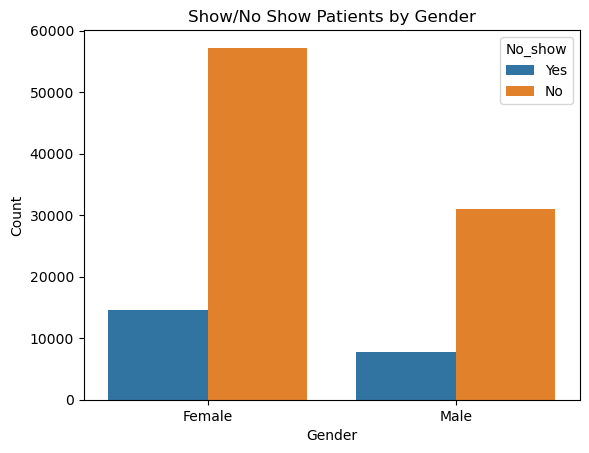

In [124]:
#Creating a countplot
ax = sns.countplot(data = merge_df, x = 'Gender', hue = 'No_show')
ax.set_title('Show/No Show Patients by Gender')
x_ticks_labels= ['Female', 'Male']
ax.set_xticklabels(x_ticks_labels)
plt.ylabel('Count')
plt.show()

### Scholarship in this data set reperesents government assistance for medical purposes

C:\Users\ajame\AppData\Local\Temp\ipykernel_14576\599613100.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks_labels)


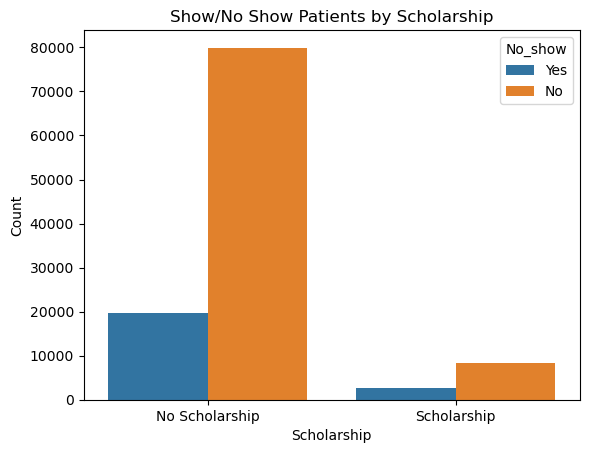

In [127]:
ax = sns.countplot(data = merge_df, x = 'Scholarship', hue = 'No_show')
ax.set_title('Show/No Show Patients by Scholarship')
x_ticks_labels = ['No Scholarship', 'Scholarship']
ax.set_xticklabels(x_ticks_labels)
plt.ylabel('Count')
plt.show()

### Creating a Countplot of patients who did not show up by Neigbourhood Class.

C:\Users\ajame\AppData\Local\Temp\ipykernel_14576\3063460407.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks_labels)


Text(0, 0.5, 'Count')

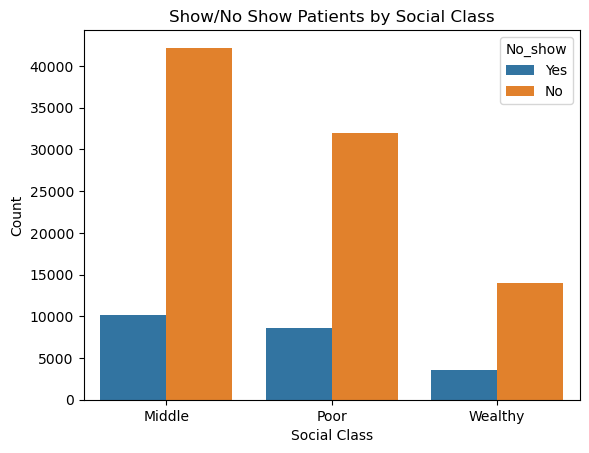

In [129]:
ax = sns.countplot(data = merge_df, x = 'Neighbourhood_Class', hue = 'No_show')
ax.set_title('Show/No Show Patients by Social Class')
x_ticks_labels = ['Middle', 'Poor', 'Wealthy']
ax.set_xticklabels(x_ticks_labels)
plt.xlabel('Social Class')
plt.ylabel('Count')

C:\Users\ajame\AppData\Local\Temp\ipykernel_16496\3156635129.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks_labels)


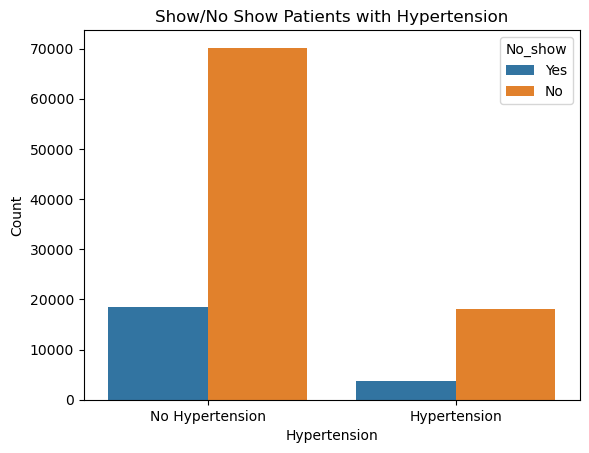

In [92]:
ax = sns.countplot(data = merge_df, x = 'Hypertension', hue = 'No_show')
ax.set_title('Show/No Show Patients with Hypertension')
x_ticks_labels = ['No Hypertension', 'Hypertension']
ax.set_xticklabels(x_ticks_labels)
plt.ylabel('Count')
plt.show()

C:\Users\ajame\AppData\Local\Temp\ipykernel_16496\1170400427.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks_labels)


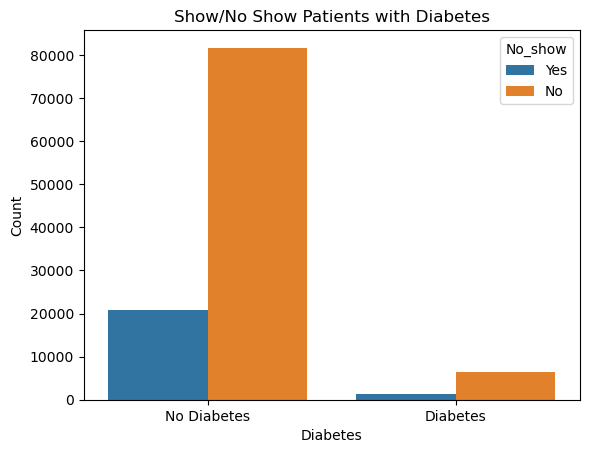

In [94]:
ax = sns.countplot(data = merge_df, x = 'Diabetes', hue = 'No_show')
ax.set_title('Show/No Show Patients with Diabetes')
x_ticks_labels = ['No Diabetes', 'Diabetes']
ax.set_xticklabels(x_ticks_labels)
plt.ylabel('Count')
plt.show()

C:\Users\ajame\AppData\Local\Temp\ipykernel_16496\753370619.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks_labels)


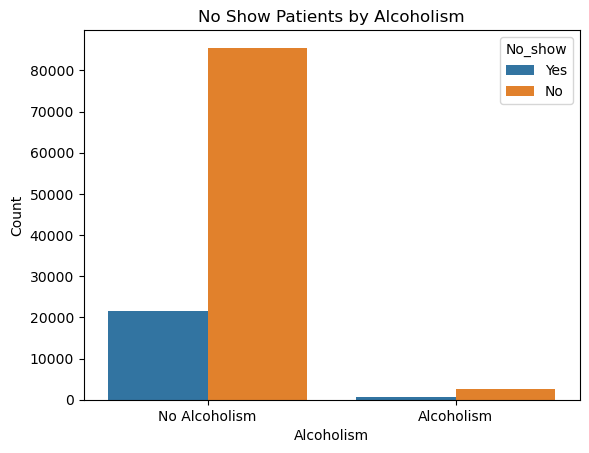

In [96]:
ax = sns.countplot(data = merge_df, x = 'Alcoholism', hue = 'No_show')
ax.set_title('No Show Patients by Alcoholism')
x_ticks_labels = ['No Alcoholism', 'Alcoholism']
ax.set_xticklabels(x_ticks_labels)
plt.ylabel('Count')
plt.show()

## Results pertaining to Neighbourhoods and Age of Patients
The top three neighbourhoods: Jardim Camburi (Middle Class), Maria Ortiz (Middle Class), and Resistencia (Poor) had the most patients who were No-Shows and overall count of patients. The average age of patients in the dataset were between 35 and 40 years old.

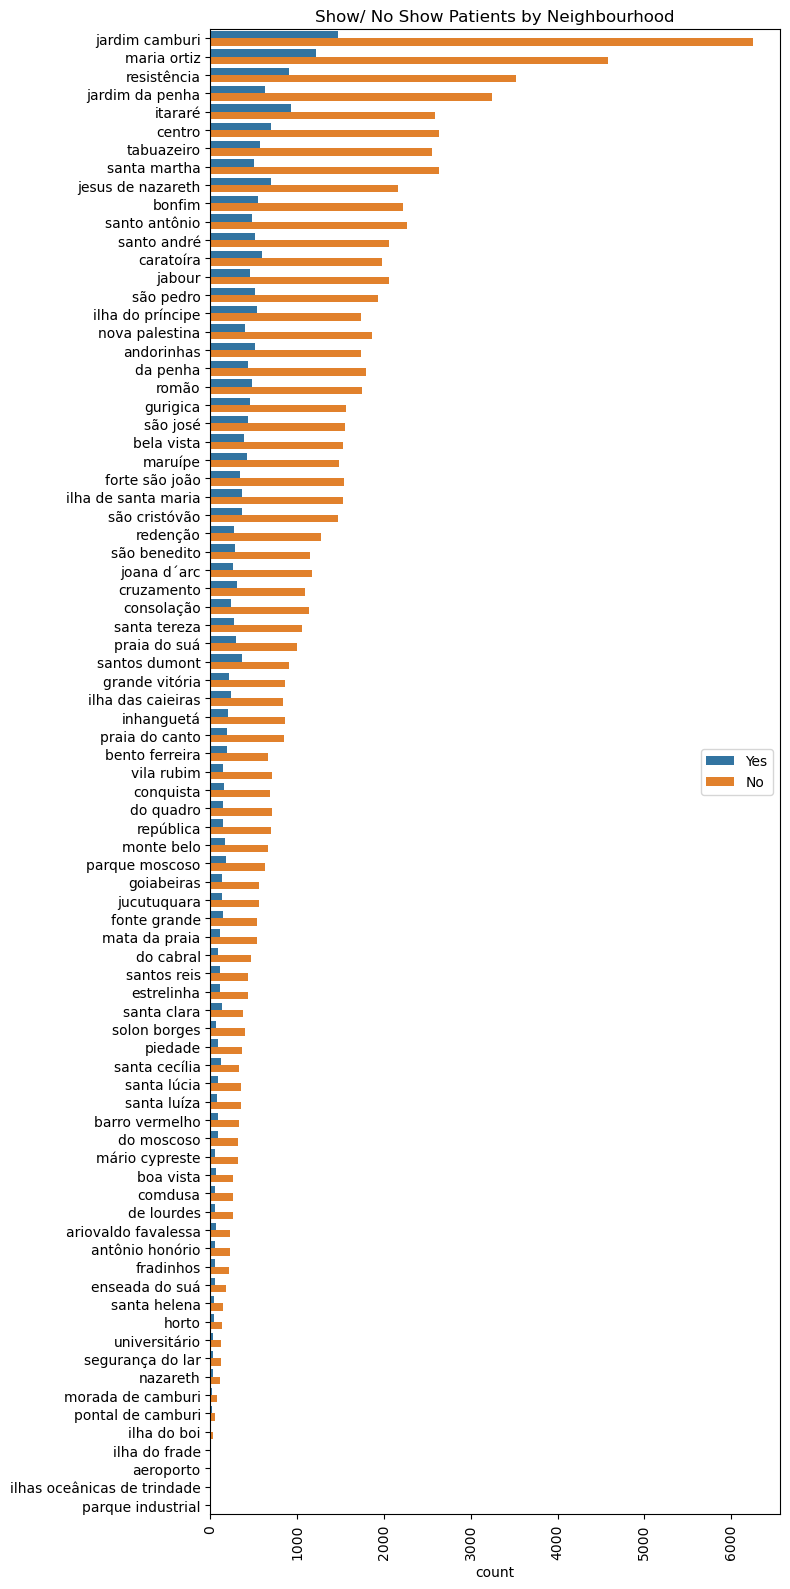

In [98]:
#Visualising the cities who had the most no_shows
plt.figure(figsize=(8,16))
plt.xticks(rotation = 90)
ax = sns.countplot(y = np.sort(merge_df.Neighbourhood), hue = 'No_show',
                   order = merge_df.Neighbourhood.value_counts().index,
                   data = merge_df)
ax.set_title('Show/ No Show Patients by Neighbourhood')
plt.legend(loc = 'center right')
plt.tight_layout()
plt.show()

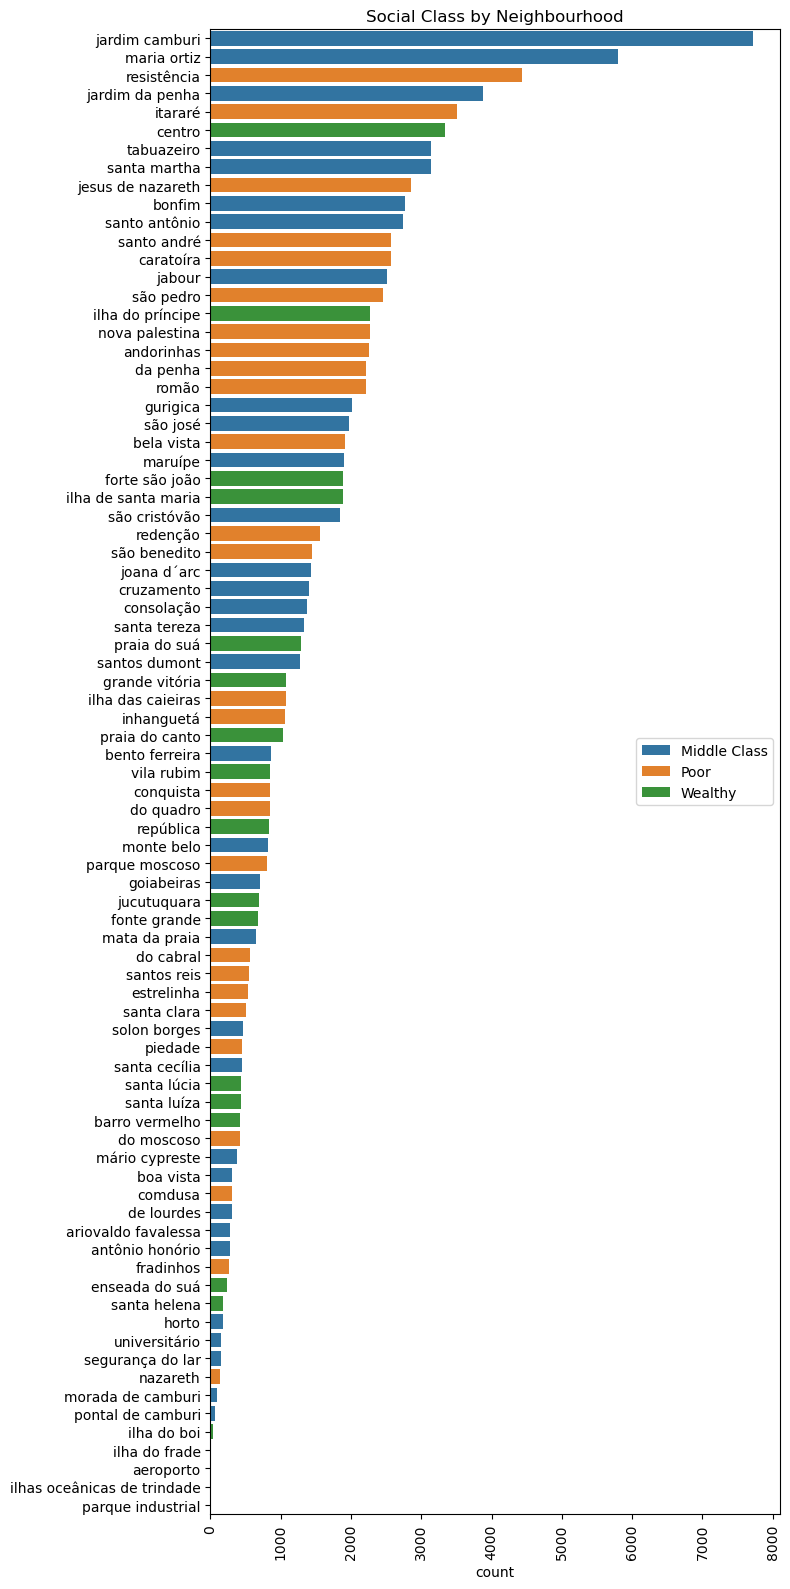

In [100]:
plt.figure(figsize=(8,16))
plt.xticks(rotation = 90)
ax = sns.countplot(y = np.sort(merge_df.Neighbourhood),
                   hue = 'Neighbourhood_Class',
                   order = merge_df.Neighbourhood.value_counts().index,
                   data = merge_df)
ax.set_title('Social Class by Neighbourhood')
plt.legend(loc = 'center right')
plt.tight_layout()
plt.show()

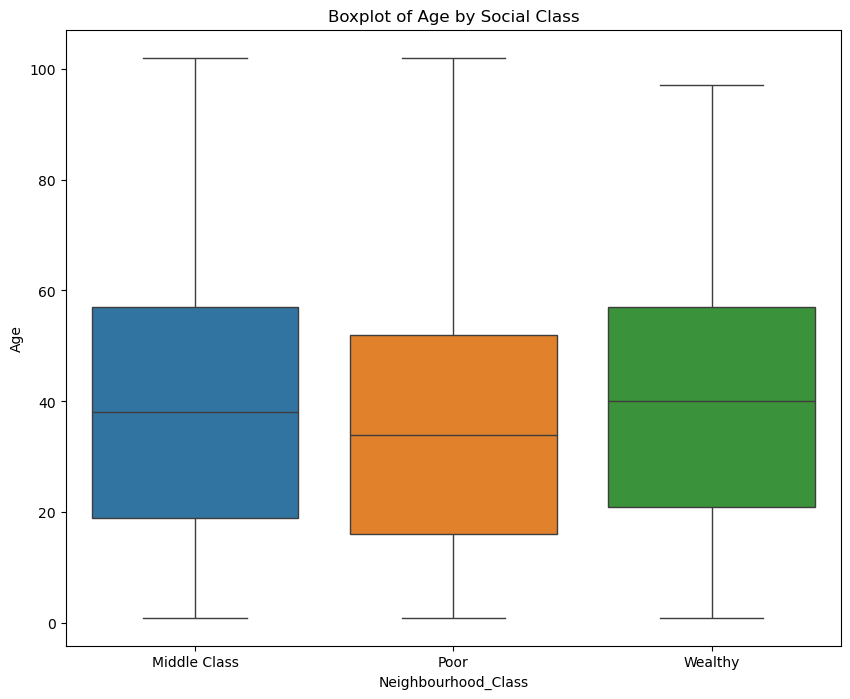

In [102]:
#Creating a boxplot for Age based on Neighbourhood_Class
fig, ax = plt.subplots(figsize = (10,8))
ax = sns.boxplot(x = 'Neighbourhood_Class', y = 'Age',
                 hue = 'Neighbourhood_Class', data = merge_df)
ax.set_title('Boxplot of Age by Social Class')
plt.show()

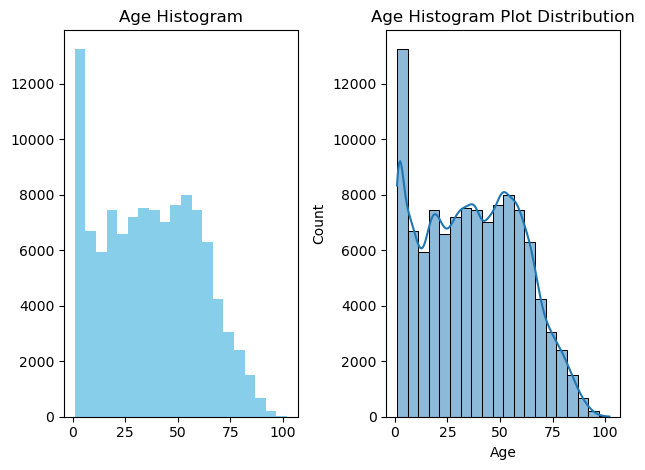

In [104]:
fig,ax = plt.subplots(1,2, tight_layout = True)
ax[0].hist(merge_df['Age'], bins = 20, color = 'skyblue')
ax[0].set_title('Age Histogram')
sns.histplot(merge_df['Age'], bins = 20, kde = True)
ax[1].set_title('Age Histogram Plot Distribution')
plt.show()


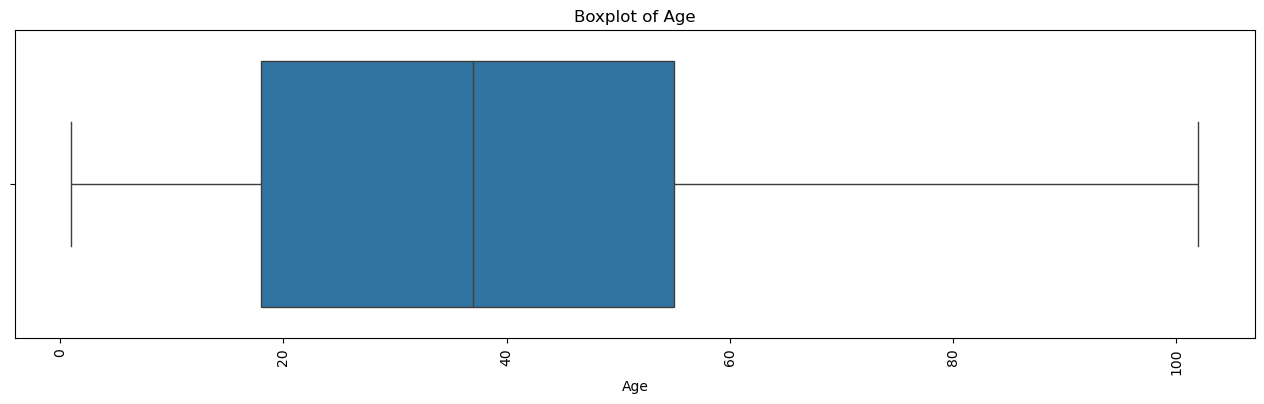

In [106]:
plt.figure(figsize = (16,4))
plt.xticks(rotation = 90)
sns.boxplot(x = 'Age', data = merge_df)
plt.title('Boxplot of Age')
plt.show()

## Results pertaining to Days Appointment Scheduled and Attended

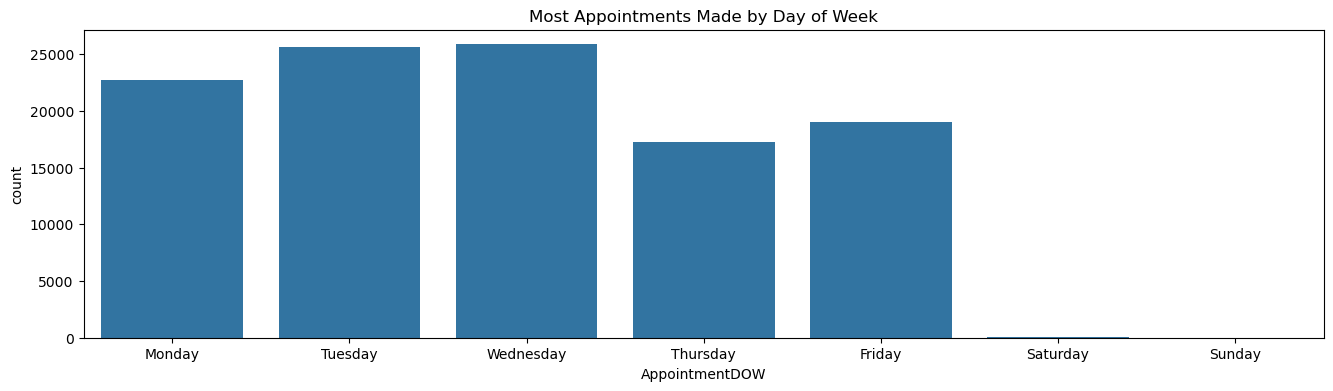

In [108]:
#Getting the days of the week for appoinment days
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize = (16,4))
sns.countplot(x = merge_df.AppointmentDOW, order = days_of_week)
plt.title('Most Appointments Made by Day of Week')
plt.show()

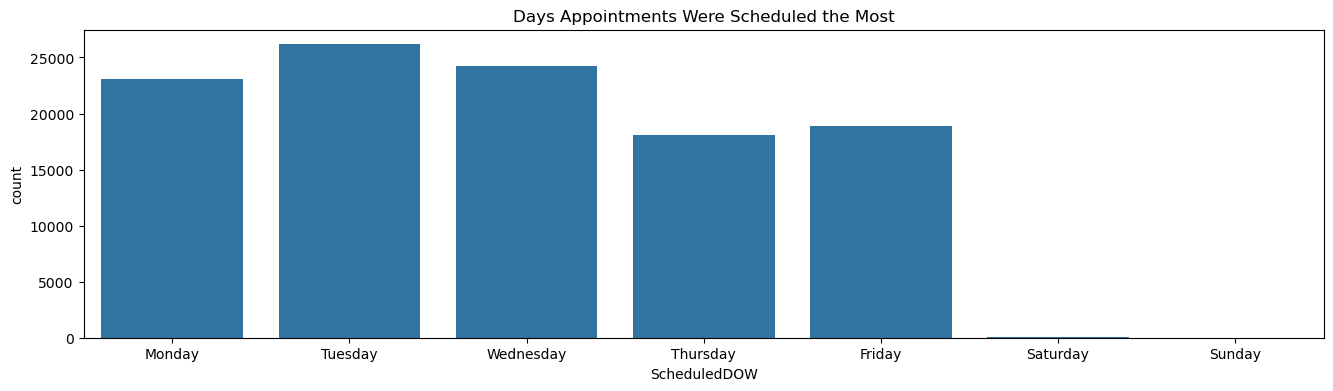

In [110]:
plt.figure(figsize = (16,4))
sns.countplot(x = merge_df.ScheduledDOW, order = days_of_week)
plt.title('Days Appointments Were Scheduled the Most')
plt.show()

AppointmentDOW
Friday       0.787727
Monday       0.793589
Saturday     0.769231
Thursday     0.806599
Tuesday      0.799126
Wednesday    0.803139
dtype: float64


C:\Users\ajame\AppData\Local\Temp\ipykernel_16496\578445965.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x = DOW_ratio.index, y = DOW_ratio,


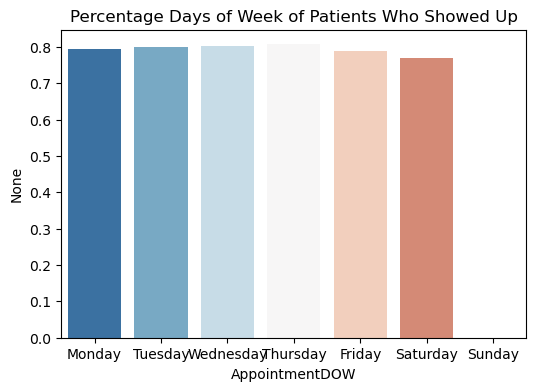

In [112]:
#Percentage of women and men where No_Show = 'No'
#Getting gender ration where No_Show == 'no'
DOW_ratio = merge_df[merge_df.No_show =='No'].groupby('AppointmentDOW').size()/merge_df.groupby('AppointmentDOW').size()
print(DOW_ratio)
plt.figure(figsize = (6,4))
ax = sns.barplot(x = DOW_ratio.index, y = DOW_ratio,
                      palette="RdBu_r", order = days_of_week)
ax.set_title('Percentage Days of Week of Patients Who Showed Up')
plt.show()

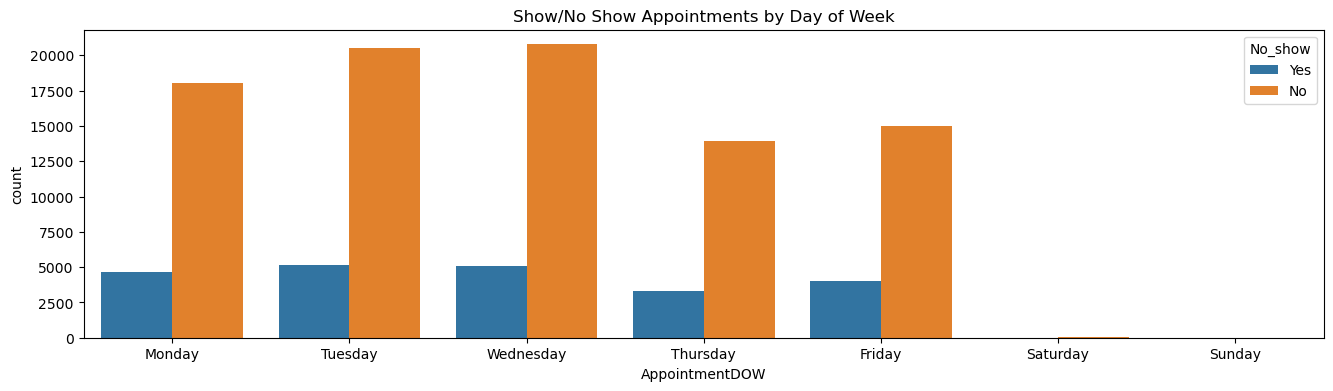

In [114]:
plt.figure(figsize = (16,4))
sns.countplot(x =merge_df.AppointmentDOW, hue =merge_df.No_show,
              order = days_of_week)
plt.title('Show/No Show Appointments by Day of Week')
plt.show()

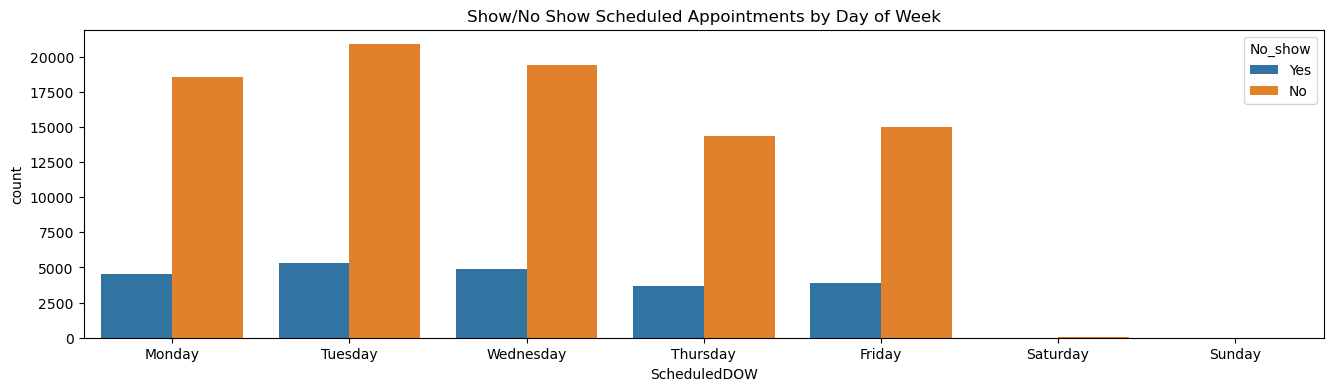

In [116]:
plt.figure(figsize = (16,4))
sns.countplot(x = merge_df.ScheduledDOW, hue = merge_df.No_show,
              order = days_of_week)
plt.title('Show/No Show Scheduled Appointments by Day of Week')
plt.show()

ScheduledDOW
Friday       0.794544
Monday       0.802487
Saturday     0.958333
Thursday     0.795307
Tuesday      0.797837
Wednesday    0.799002
dtype: float64


C:\Users\ajame\AppData\Local\Temp\ipykernel_16496\1385321438.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = scheduled_ratio.index, y = scheduled_ratio, palette='RdBu_r', order = days_of_week)


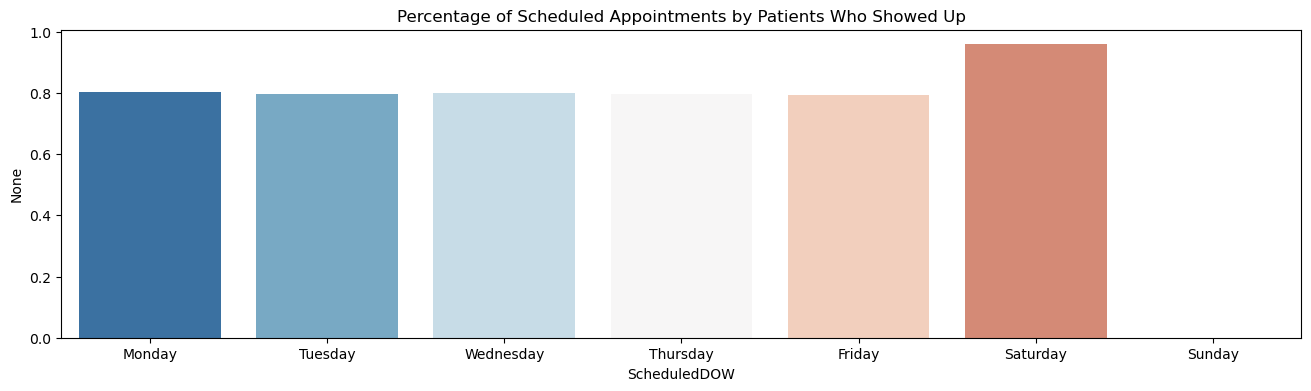

In [118]:
scheduled_ratio = merge_df[merge_df.No_show =='No'].groupby('ScheduledDOW').size()/merge_df.groupby('ScheduledDOW').size()
print(scheduled_ratio)
plt.figure(figsize = (16,4))
sns.barplot(x = scheduled_ratio.index, y = scheduled_ratio, palette='RdBu_r', order = days_of_week)
plt.title('Percentage of Scheduled Appointments by Patients Who Showed Up')
plt.show()

Neighbourhood
aeroporto              0.875000
andorinhas             0.770593
antônio honório        0.815498
ariovaldo favalessa    0.780142
barro vermelho         0.784870
                         ...   
são josé               0.783401
são pedro              0.789624
tabuazeiro             0.817311
universitário          0.789474
vila rubim             0.834313
Length: 81, dtype: float64


C:\Users\ajame\AppData\Local\Temp\ipykernel_16496\22819406.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = pop_ratio.index, y = pop_ratio, palette = 'RdBu_r')


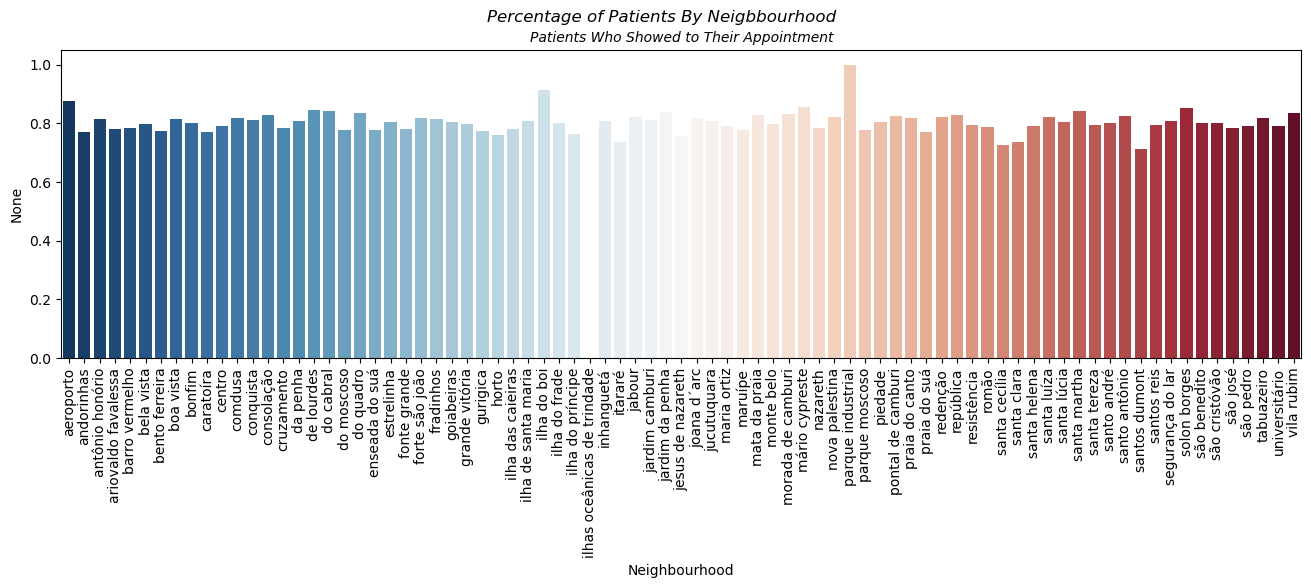

In [120]:
pop_ratio = merge_df[merge_df.No_show =='No'].groupby('Neighbourhood').size()/merge_df.groupby('Neighbourhood').size()
print(pop_ratio)
plt.figure(figsize = (16,4))
plt.xticks(rotation = 90)
sns.barplot(x = pop_ratio.index, y = pop_ratio, palette = 'RdBu_r')
plt.suptitle('Percentage of Patients By Neigbbourhood',
             fontstyle = 'oblique') #Header
plt.title('Patients Who Showed to Their Appointment', fontsize = 10,
          fontstyle = 'italic') #subtitle
plt.show()

C:\Users\ajame\AppData\Local\Temp\ipykernel_16496\2200084196.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = np.sort(merge_df.Neighbourhood), palette = 'icefire')


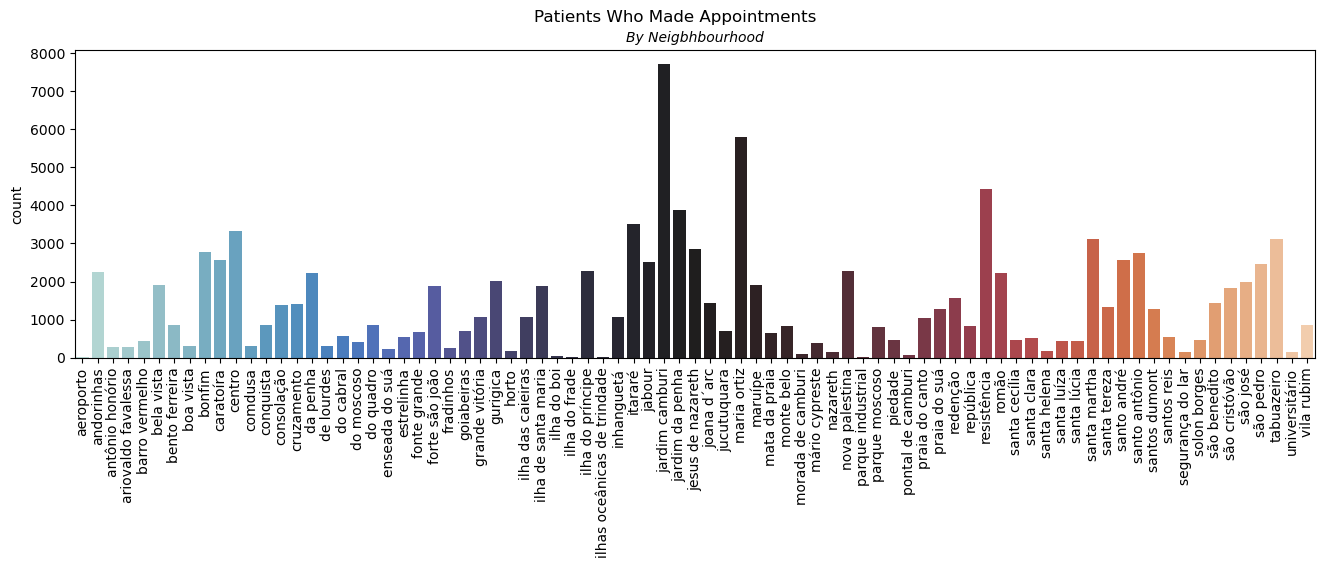

In [122]:
plt.figure(figsize = (16,4))
plt.xticks(rotation = 90)
sns.countplot(x = np.sort(merge_df.Neighbourhood), palette = 'icefire')
plt.suptitle('Patients Who Made Appointments')
plt.title('By Neigbhbourhood', fontsize = 10, fontstyle = 'italic')
plt.show()

C:\Users\ajame\AppData\Local\Temp\ipykernel_16496\2523937798.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = np.sort(merge_df.Neighbourhood),stat = 'percent', palette = 'magma')


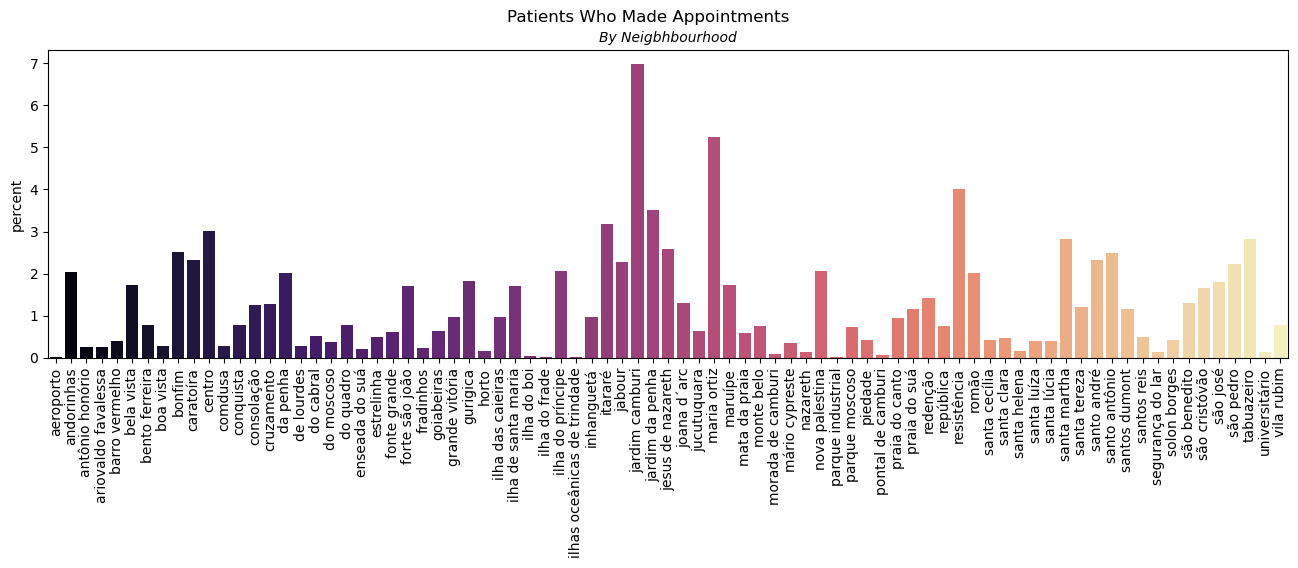

In [124]:
plt.figure(figsize = (16,4))
plt.xticks(rotation = 90)
sns.countplot(x = np.sort(merge_df.Neighbourhood),stat = 'percent', palette = 'magma')
plt.suptitle('Patients Who Made Appointments')
plt.title('By Neigbhbourhood', fontsize = 10, fontstyle = 'italic')
plt.show()

### Creating Logistic Regression Model

In [131]:
#Creating Logistic Regression Model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, classification_report

In [133]:
#Changing gender from M and F to 1 and 0
merge_df['Gender'] = merge_df['Gender'].map({'M': 1, 'F': 0}) #1 = Male, 0 = Female
merge_df.head()

,Gender,ScheduledDay,ScheduledDOW,AppointmentDay,AppointmentDOW,Days_Btwn,Age,Neighbourhood,City,State,...,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show,Zip_code,WeekDay_Appointment,Days_In_Advanced,Neighbourhood_Class
0,0,2016-04-18,Monday,2016-05-05,Thursday,17 days,37,aeroporto,Vitória,Espirito Santo,...,0,0,0,0,0,Yes,29075-000,4,17,Middle Class
1,0,2016-05-02,Monday,2016-05-09,Monday,7 days,58,aeroporto,Vitória,Espirito Santo,...,0,0,0,0,0,No,29075-000,1,7,Middle Class
2,0,2016-05-10,Tuesday,2016-05-12,Thursday,2 days,58,aeroporto,Vitória,Espirito Santo,...,0,0,0,0,0,No,29075-000,4,2,Middle Class
3,1,2016-05-06,Friday,2016-05-06,Friday,0 days,51,aeroporto,Vitória,Espirito Santo,...,0,0,0,0,0,No,29075-000,5,0,Middle Class
4,0,2016-03-03,Thursday,2016-05-17,Tuesday,75 days,64,aeroporto,Vitória,Espirito Santo,...,1,0,0,0,0,No,29075-000,2,75,Middle Class


In [135]:
merge_df['target'] = merge_df['No_show'].map({'No': 0, 'Yes': 1})

In [137]:
#Checking unique values of differnt cols
merge_df['Days_Btwn'].nunique()

129

In [139]:
merge_df['Days_Btwn'].describe()

count                        110517
mean     10 days 04:25:13.135535709
std      15 days 06:07:26.049984196
min                 0 days 00:00:00
25%                 0 days 00:00:00
50%                 4 days 00:00:00
75%                15 days 00:00:00
max               179 days 00:00:00
Name: Days_Btwn, dtype: object

In [141]:
#Convertitng Days_Btwn to fload
merge_df['Days_Btwn']= merge_df['Days_Btwn'].dt.days
merge_df['Days_Btwn'].describe()

count    110517.000000
mean         10.184180
std          15.255163
min           0.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: Days_Btwn, dtype: float64

In [143]:
#Getting dummies
categoric_cols = pd.get_dummies(merge_df, columns = ['Neighbourhood_Class',
                                                     'ScheduledDOW', 'AppointmentDOW',
                                                     'City','State', 'Zip_code'
                                                     ], drop_first= True)

#Assigning numbers to Neighbourhoods based on how often it appears
neigh_freq = merge_df['Neighbourhood'].value_counts().to_dict()
merge_df['Neighbourhood'] = merge_df['Neighbourhood'].map(neigh_freq)

#### Since we already have ScheduledDay and AppointmentDOW, we can delete ScheduledDay and AppointmentDay since they won't work with Logistgic Reg

In [145]:
merge_df.drop(['ScheduledDay', 'AppointmentDay'], axis = 1, inplace= True)

In [147]:
merge_df['Days_In_Advanced'].describe()
#There are -1s for Days_in_Advanced. changing those to 0s
merge_df['Days_In_Advanced'] = merge_df['Days_In_Advanced'].replace(-1,0)

In [149]:
merge_df['Days_In_Advanced'].describe() #Making sure the code above worked

count    110517.000000
mean         10.184180
std          15.255163
min           0.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: Days_In_Advanced, dtype: float64

In [151]:
merge_df.head()

,Gender,ScheduledDOW,AppointmentDOW,Days_Btwn,Age,Neighbourhood,City,State,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show,Zip_code,WeekDay_Appointment,Days_In_Advanced,Neighbourhood_Class,target
0,0,Monday,Thursday,17,37,8,Vitória,Espirito Santo,0,0,0,0,0,0,Yes,29075-000,4,17,Middle Class,1
1,0,Monday,Monday,7,58,8,Vitória,Espirito Santo,0,0,0,0,0,0,No,29075-000,1,7,Middle Class,0
2,0,Tuesday,Thursday,2,58,8,Vitória,Espirito Santo,0,0,0,0,0,0,No,29075-000,4,2,Middle Class,0
3,1,Friday,Friday,0,51,8,Vitória,Espirito Santo,0,0,0,0,0,0,No,29075-000,5,0,Middle Class,0
4,0,Thursday,Tuesday,75,64,8,Vitória,Espirito Santo,0,1,0,0,0,0,No,29075-000,2,75,Middle Class,0


In [153]:
#Getting Numeric features
num_cols = ['Gender', 'Days_Btwn', 'Age', 'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received', 'Days_In_Advanced']


In [155]:
#Collecating all the dunmmy vars
dummy_vars = [col for col in categoric_cols.columns if col.startswith(
    ('Neighbourhood_Class_', 'ScheduledDOW_', 'AppointmentDOW_', 'City_', 'State_',
    'Zip_code_')
)]

### Let's Start making our Logistic Regression!!

Splitting the train and test set to 80/20 meaning 80% training, 20% testing. Then `StandardScaler()` was used to scale the dataset

In [171]:
#Importing StandardScaler
from sklearn.preprocessing import StandardScaler
feature_cols = num_cols + dummy_vars
X = categoric_cols[feature_cols]
y = merge_df['target']
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled [num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled [ num_cols] = scaler.transform(X_test[num_cols])

### Fitting the Model and balancing it to make better predictions

In [173]:
#Fitting the Model
model = LogisticRegression(max_iter = 1000, class_weight= 'balanced')
model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

### Confusion Matrix and Classification Report for Logistic Regression

#### Confusion Matrix
The `confusion matrix`shows the number of True Positives(TP), True Negatives(TN), False Positives (FP), and False Negatives(FN).
The way to read the Confusion matrix is:
|             | Actual Positive | Actual Negative |
| :---------- |:----------| :---------- |
| **Predicted Positive** | True Positive (TP) | False Negative (FN) |
| **Predicted Negative** | False Positive (FP) | True Negative (TN) |
The **true positive** is when a model actually predicts a positve sample, in this case it is patients who show up to their appointment. A **true negative** is when a model accurately predicts a negative sample, in this case the negatice sample are patients who are a no-show. A **false positive** is when the model, in this case, classifies a no-show patient as a patient who shows up. Finally, a **false negative** is when the model classifies a no-show as a patient show is showing up.

---------------------------------------------------

#### Classification Report

**Precision** for patients who are showing up `Class 0` is 0.86 (86%), which means out of all the patients the model will predict that 86% of the patients will show up to their appoinment. However, in this model we want to look at **recall**. The **recall** is the percentage a model can identify a certain classification. For example, in this model, out of the patients labelled as show-ups `(Class 0 )`,the model correctly identified 0.69 (69%) of them. The **recall** for no-shows `(Class 1)`, 0.57 (57%) were correctly identified as no-shows. The model in totality was ~ 67% accurate.

In [175]:
#Evaluating Model
y_pred = model.predict(X_test_scaled)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[12055  5525]
 [ 1929  2595]]
Accuracy Score: 0.662775968150561
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.69      0.76     17580
           1       0.32      0.57      0.41      4524

    accuracy                           0.66     22104
   macro avg       0.59      0.63      0.59     22104
weighted avg       0.75      0.66      0.69     22104



### Tuning the Logistic Regression

In [177]:
#Tuning Probability Threshold
y_prob = model.predict_proba(X_test_scaled) [:, 1]

y_pred_cust = (y_prob >= 0.4).astype(int)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_cust))
print("Classification Report:\n", classification_report(y_test, y_pred_cust))

Confusion Matrix:
 [[ 6369 11211]
 [  686  3838]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.36      0.52     17580
           1       0.26      0.85      0.39      4524

    accuracy                           0.46     22104
   macro avg       0.58      0.61      0.45     22104
weighted avg       0.77      0.46      0.49     22104



Since the logistic regression with the first confusion matrix was not tuned, below is a few differnt thresholds to try to get the best results out of this model for the recall for (Class 0 ). Based on these values, it is somewhere between 0.4 and 0.5.

In [179]:
for t in [0.3, 0.4, 0.5, 0.6]:
    y_pred_t = (y_prob >= t).astype(int)
    print(f"Threshold: {t}")
    print(confusion_matrix(y_test, y_pred_t))
    print(classification_report(y_test, y_pred_t))
    print("-----------")

Threshold: 0.3
[[  719 16861]
 [   57  4467]]
              precision    recall  f1-score   support

           0       0.93      0.04      0.08     17580
           1       0.21      0.99      0.35      4524

    accuracy                           0.23     22104
   macro avg       0.57      0.51      0.21     22104
weighted avg       0.78      0.23      0.13     22104

-----------
Threshold: 0.4
[[ 6369 11211]
 [  686  3838]]
              precision    recall  f1-score   support

           0       0.90      0.36      0.52     17580
           1       0.26      0.85      0.39      4524

    accuracy                           0.46     22104
   macro avg       0.58      0.61      0.45     22104
weighted avg       0.77      0.46      0.49     22104

-----------
Threshold: 0.5
[[12055  5525]
 [ 1929  2595]]
              precision    recall  f1-score   support

           0       0.86      0.69      0.76     17580
           1       0.32      0.57      0.41      4524

    accuracy        

This **Precision/Recall** shows the **recall** and **precision** at each threshold. The **blue line** is the **precision line**. The precision line shows that at a low threshold would predict almost all no-shows, but there would be a lot of false positves, byt the precision will be low. Meanwhile, if a high threshold is selected for precision, the trade-off will be a low **recall**, meaning most of the no-shows will be missed. The balance appears to be somewhere in the middle, however instead of guessing the best threshold based on this graph, the F1-score will be graphed to get the correct best threshold for this model. 

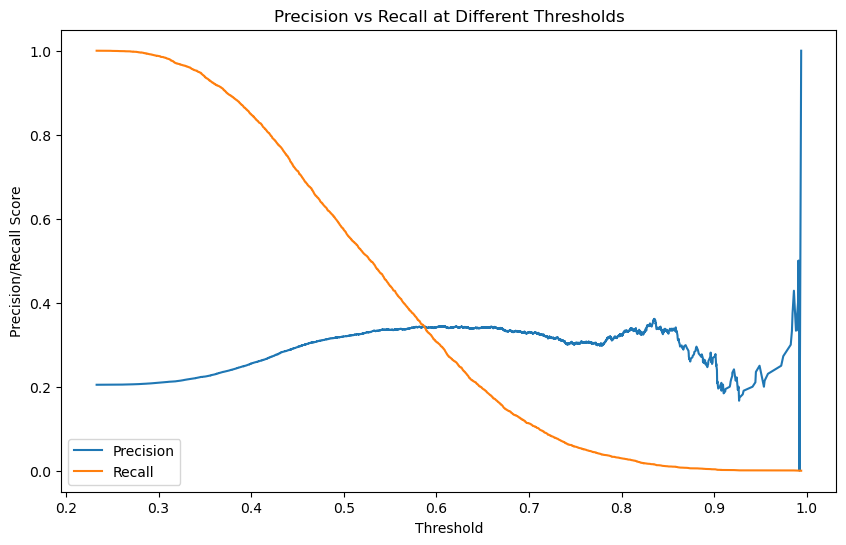

In [181]:
#Plotting precision - recall vs threshold curve
from sklearn.metrics import precision_recall_curve, f1_score
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
plt.figure (figsize = (10,6))
plt.plot(thresholds, precision[1:], label = 'Precision')
plt.plot(thresholds, recall[1:], label = 'Recall')
plt.xlabel ('Threshold')
plt.ylabel ('Precision/Recall Score')
plt.title('Precision vs Recall at Different Thresholds')
plt.legend()
plt.show()


### Plotting the F1 score to get the best threshold.

The best threshold for the logistic model is 0.46

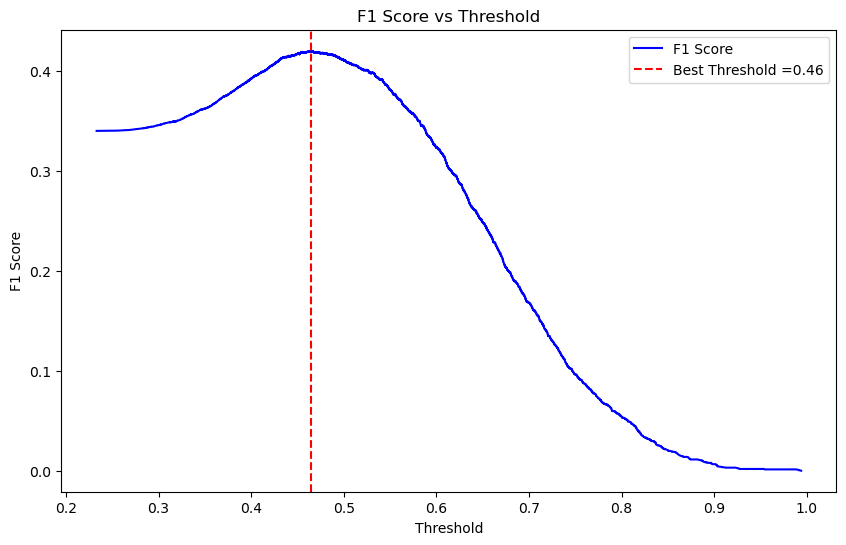

The Best Threshold is: 0.46
The Best F1 Score is: 0.42


In [183]:
#Plottin the F-1 score for differnt thresholds
plt.figure(figsize = (10, 6))
#Calcs the f1_score for each threshold
f1_scores  = 2 * (precision * recall) / (precision + recall + 1e-8)

#Finds the index for the best f1_score
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

#Plotting F_1 vs Threshold
plt.plot(thresholds, f1_scores[:-1], label = 'F1 Score', color = 'blue')
plt.axvline(x = best_threshold, color = 'red', linestyle = '--', label = f'Best Threshold ={best_threshold:.2f}')
plt.title( 'F1 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

print(f'The Best Threshold is: {best_threshold:.2f}')
print(f'The Best F1 Score is: {best_f1:.2f}')

### Applyong the optimal threshold

This improved the recall for patients who were a no-show by about 10%. Now, 68% of no-shows are correctly being identified

In [187]:
#Applying optimal threshold
y_pred_opt = (y_prob >= 0.46).astype(int)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_opt))
print('Classification Report:\n', classification_report(y_test, y_pred_opt))

Confusion Matrix:
 [[10418  7162]
 [ 1431  3093]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.59      0.71     17580
           1       0.30      0.68      0.42      4524

    accuracy                           0.61     22104
   macro avg       0.59      0.64      0.56     22104
weighted avg       0.76      0.61      0.65     22104



### Getting the coefficients for the logistic regression, and whether the features for the coefficients are more or less likely to show up to their appointments

In [189]:
#Gettign the coefficients
coeff_df = pd.DataFrame({'Feature': feature_cols,
                     'Coefficients': model.coef_[0]})

#Interpreteations of coefficients
coeff_df['Absolute Coefficients'] = coeff_df['Coefficients'].abs()
coeff_df ['Effect Direction'] = coeff_df['Coefficients'].apply(lambda x: 'Increase No Show' if x > 0 else 'Decrease No Show')

#Sorts by importance
coeff_df.sort_values(by = 'Absolute Coefficients', ascending = False, inplace = True)
coeff_df.head()

,Feature,Coefficients,Absolute Coefficients,Effect Direction
18,AppointmentDOW_Saturday,0.560912,0.560912,Increase No Show
45,Zip_code_29090-000,-0.548536,0.548536,Decrease No Show
13,ScheduledDOW_Saturday,-0.500034,0.500034,Decrease No Show
41,Zip_code_29060-000,-0.479587,0.479587,Decrease No Show
38,Zip_code_29053-000,-0.442402,0.442402,Decrease No Show


### Plotting the top 20 features

Those who have an appointment on Saturdays are the most likely to not show up to their appointment. In addition, those who make their appointments further in advance are also less likely to show up to their appointment. Those who have more days between the day they scheduled their appointment and their actual appointment are more likely to not show up to their appointment as well.

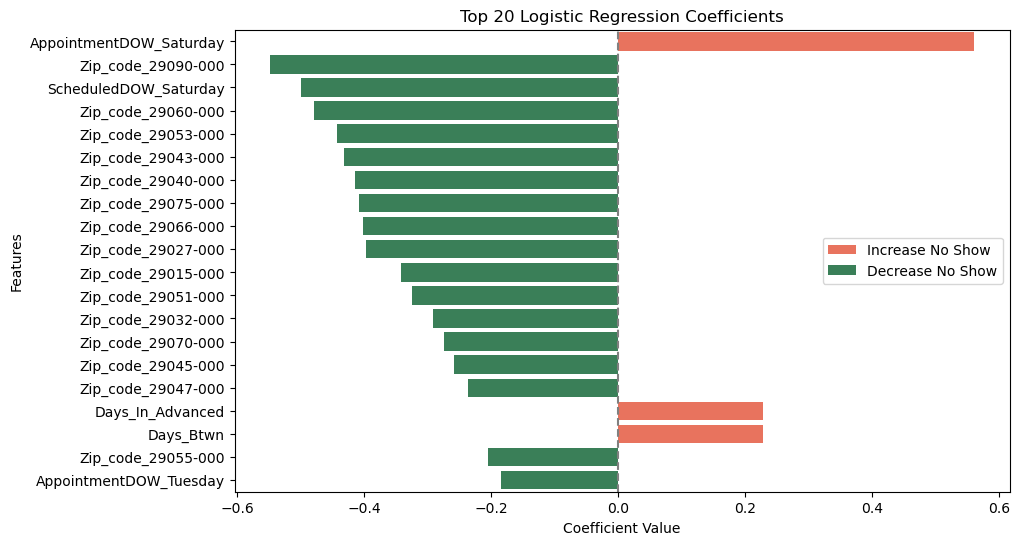

In [191]:
#Plotting top 20 features
top_feat = 20
top_coeff = coeff_df.head(top_feat)

plt.figure(figsize = (10, 6))
sns.barplot( data = top_coeff, y = 'Feature', x = 'Coefficients',
            hue = 'Effect Direction',
             palette = {'Increase No Show': 'tomato', 'Decrease No Show': 'seagreen'})
plt.axvline(0, color = 'gray', linestyle = '--')
plt.title (f'Top {top_feat} Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.legend(loc = 'center right')
plt.show()

If XGBoost is not already installed in an IDE that uses Python, here is the code to download it

In [174]:
#installing XGBoost to compare Log model with
!pip install xgboost

### Creating and fitting the XGBoost Model

In [193]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

#Training XGBoost model with imbalanced datat
xgb_model = XGBClassifier( use_label_encoder = False,
                          eval_metric = 'logloss',
                           scale_pos_weight = len(y_train[y_train ==0])/ len(y_train[y_train == 1]),
                           random_state = 42)

xgb_model.fit(X_train, y_train)

C:\Users\ajame\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:22:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

### Getting the pobabilities, confusion matrix,and classification report

The `recall` for the `XGboost` model without tuning is 0.57 (57%). This means without tuning, the model is capturing those labeled as "no-show" 57% of the time. `AUC` stands for Area Under the Curve, and the area under of the curve is basically saying how much of of the model is capturing the true positives for this dataset. The answer to that is capturing 60% of the true positives.

In [205]:
#Getting Predictions and Probabilities

y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

#Uses the same threshold from F1 Score vs Threshold graph
y_pred_xgb = xgb_model.predict(X_test>= 0.52).astype(int)

#Getting metrics
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_xgb))
print('Classification Report:\n',  classification_report(y_test, y_pred_xgb))
print('Accuracy Score:\n', accuracy_score(y_test, y_pred_xgb))
print('AUC:\n', roc_auc_score(y_test, y_pred_xgb))

Confusion Matrix:
 [[11146  6434]
 [ 1925  2599]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.63      0.73     17580
           1       0.29      0.57      0.38      4524

    accuracy                           0.62     22104
   macro avg       0.57      0.60      0.56     22104
weighted avg       0.74      0.62      0.66     22104

Accuracy Score:
 0.6218331523706117
AUC:
 0.6042537637718289


### Plotting the Precision vs Recall graph

The graph is similar to the logistic regression where the lower the threshold, the more the model will capture the no-shows, but there will be a lot of false positives. The best threshold will be represented below this graph.

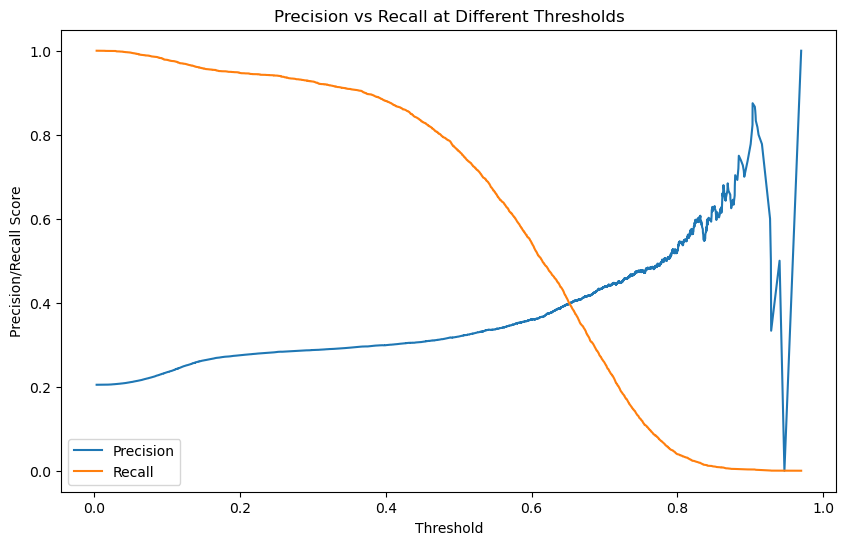

In [197]:
#Getting better threshold for XGBoost
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_xgb)
plt.figure (figsize = (10,6))
plt.plot(thresholds, precision[1:], label = 'Precision')
plt.plot(thresholds, recall[1:], label = 'Recall')
plt.xlabel ('Threshold')
plt.ylabel ('Precision/Recall Score')
plt.title('Precision vs Recall at Different Thresholds')
plt.legend()
plt.show()


### Best threshold for `XGboost` in the plot is 0.49, however, the calculated threshold will be used since it is not rounded to the highest hundreths place

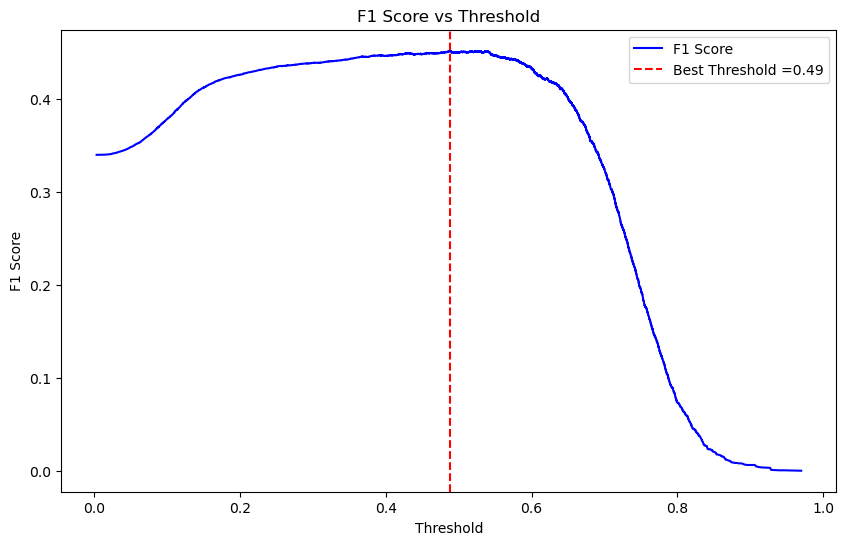

The Best Threshold is: 0.49
The Best F1 Score is: 0.45


In [199]:
##Graphing F1-score for best threshold
plt.figure(figsize = (10, 6))
#Calcs the f1_score for each threshold
f1_scores  = 2 * (precision * recall) / (precision + recall + 1e-8)

#Finds the index for the best f1_score
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

#Plotting F_1 vs Threshold
plt.plot(thresholds, f1_scores[:-1], label = 'F1 Score', color = 'blue')
plt.axvline(x = best_threshold, color = 'red', linestyle = '--', label = f'Best Threshold ={best_threshold:.2f}')
plt.title( 'F1 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

print(f'The Best Threshold is: {best_threshold:.2f}')
print(f'The Best F1 Score is: {best_f1:.2f}')

In [201]:
f1_scores = [f1_score(y_test, y_prob_xgb > t) for t in thresholds]
best_thresh = thresholds[np.argmax(f1_scores)]
print("Best threshold by F1 score:", best_thresh)

Best threshold by F1 score: 0.48835725


### Looking at the Classificatin Report for `Class 1's Recall` 

The recall for those were correctly identified as as no-shows was 0.78 (78%)

In [217]:
y_pred_xgb_opt = (y_prob_xgb > 0.488).astype(int) #Decided to go with value closer to Best threshold than the graph for mor accuracy
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb_opt))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb_opt))
print("Accuracy Score:\n", accuracy_score(y_test, y_pred_xgb_opt))


Confusion Matrix:
 [[9935 7645]
 [ 974 3550]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.57      0.70     17580
           1       0.32      0.78      0.45      4524

    accuracy                           0.61     22104
   macro avg       0.61      0.67      0.57     22104
weighted avg       0.79      0.61      0.65     22104

Accuracy Score:
 0.6100705754614549


### Visualising Shapley values

Shapley values are great use for machinie learning techniques. It shows the features that a model views as "important". In this `XGBoost` model `Days_Btwn` and `Age` are the most imporant features in the model.

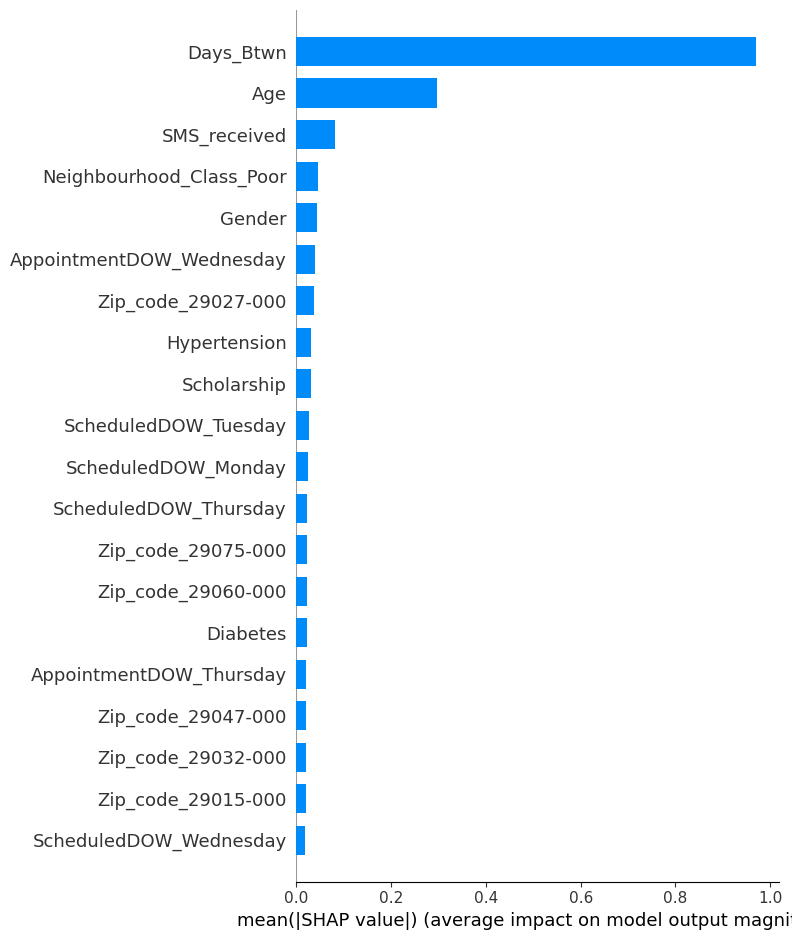

In [235]:
import shap
explainer = shap.TreeExplainer(xgb_model)

shap_vals = explainer.shap_values(X_test)
shap.summary_plot(shap_vals, X_test, plot_type = 'bar')

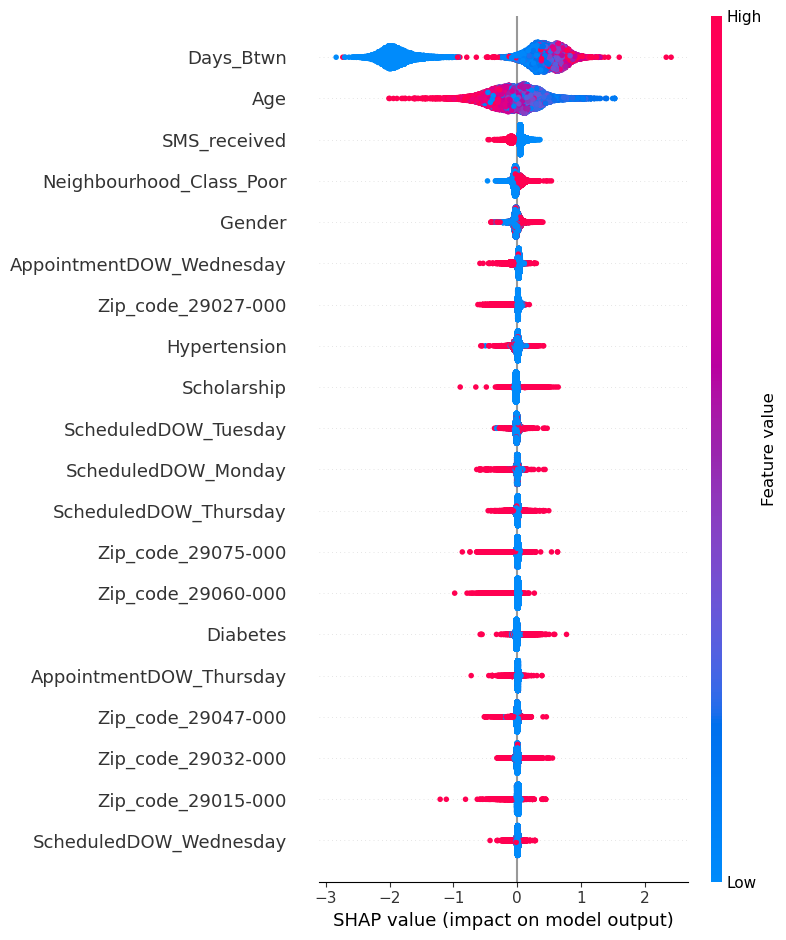

In [237]:
#Using Shapley visualisation to see the variables that are driving the XGBoost model
import shap
X_for_shap = X_test.copy()
explainer = shap.TreeExplainer(xgb_model)
shap_vals = explainer.shap_values(X_for_shap)
shap.summary_plot(shap_vals, X_for_shap)

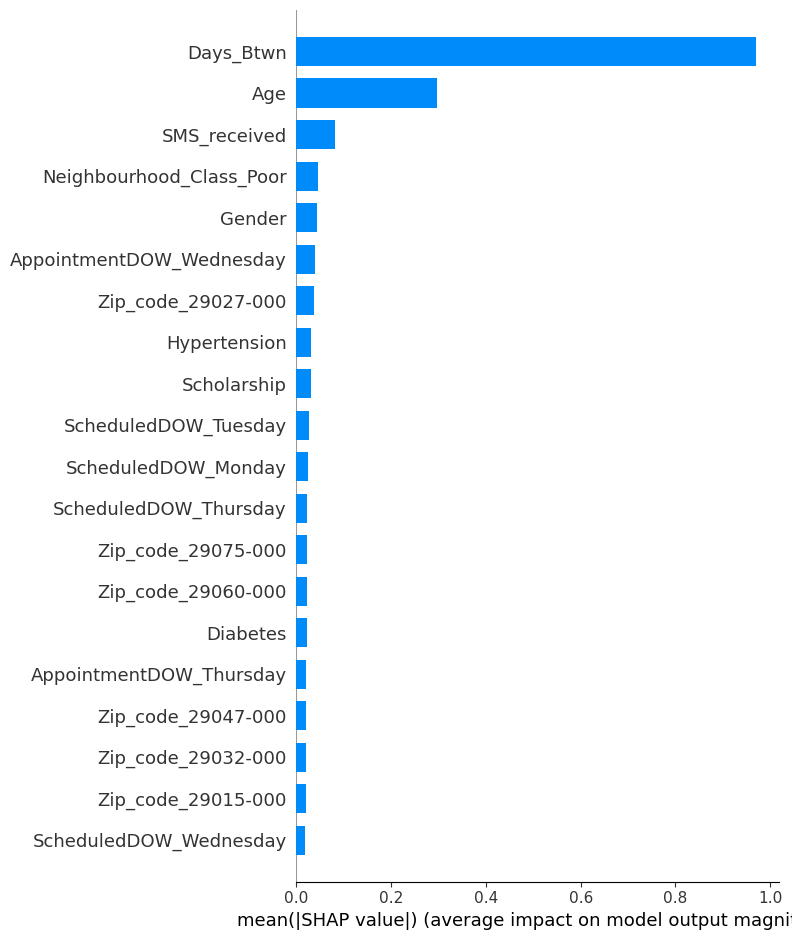

In [221]:
shap.summary_plot(shap_vals, X_test, plot_type = 'bar') #For easier understanding of Shapley graph above

### Creating dependency plots
* There are no interactions `Days_Btwn` and `SMS_Received`
* There are possible interactions between `Age` and `Neigbourhood_Class_Poor`, as those who are under ~ 20 years old are more likely to not show up to their appointment when they live in a working class neighbourhood.
* The ame interaction is between `Age` and `Neigbourhood_Class_Wealthy`
* There are no interactions between `Days_Btwn` and `Gender`

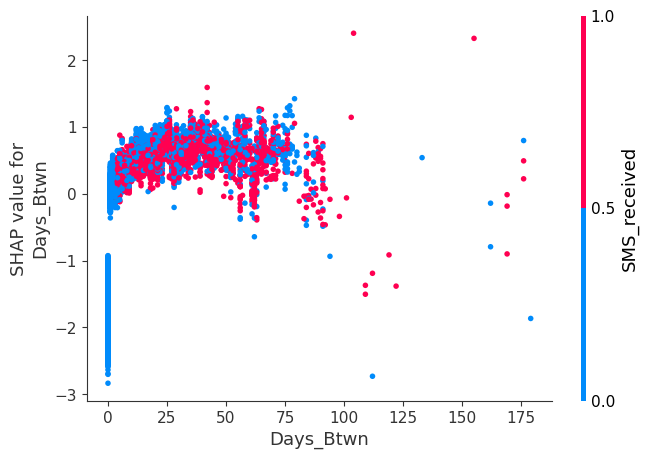

In [186]:
shap.dependence_plot(
    'Days_Btwn',
    shap_vals,
    X_test,
    interaction_index='SMS_received'
)

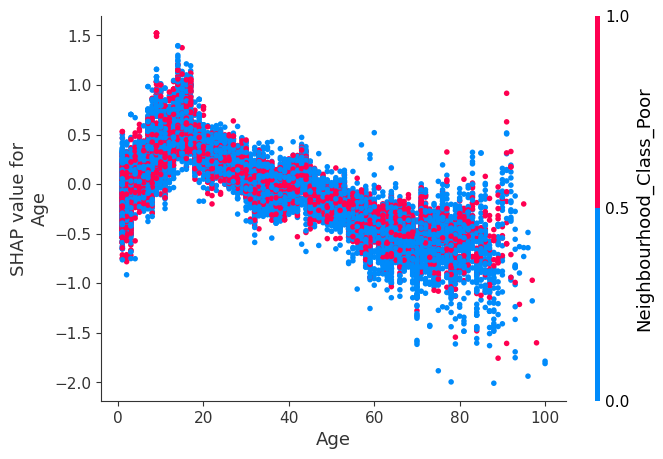

In [188]:
shap.dependence_plot(
    'Age',
    shap_vals,
    X_test,
    interaction_index='Neighbourhood_Class_Poor'
) #Higher SHAP vals mean more likely to not show up

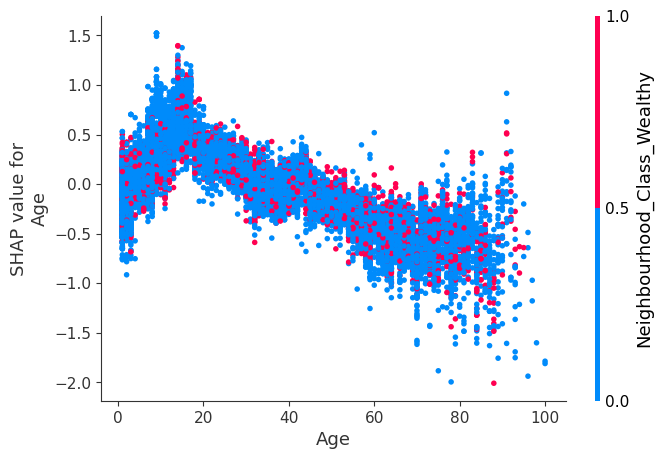

In [190]:
shap.dependence_plot(
    'Age',
    shap_vals,
    X_test,
    interaction_index='Neighbourhood_Class_Wealthy'
)

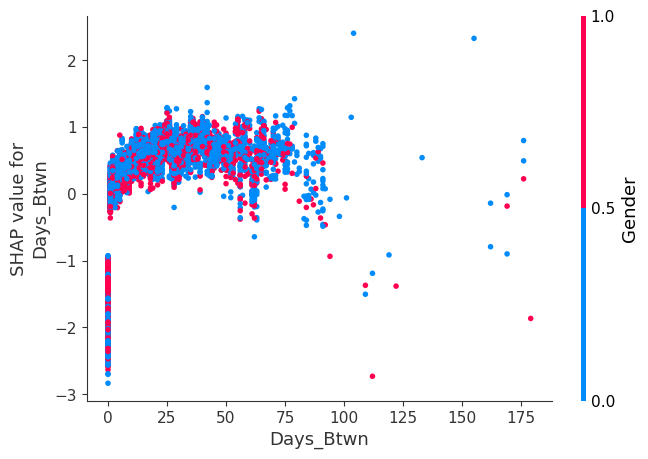

In [192]:
shap.dependence_plot(
    'Days_Btwn',
    shap_vals,
    X_test,
    interaction_index='Gender'
) #Mostly 0

### Creating the Receiver-Operating Characteristic Curve (ROC curve)

The ROC curve helps data scientists/analysts visualise how well a binary classification model is at distinguishing between different classes. In the graph below the XGBoost model is better at distinguishing between different classes compared to the Logistic Regression model.

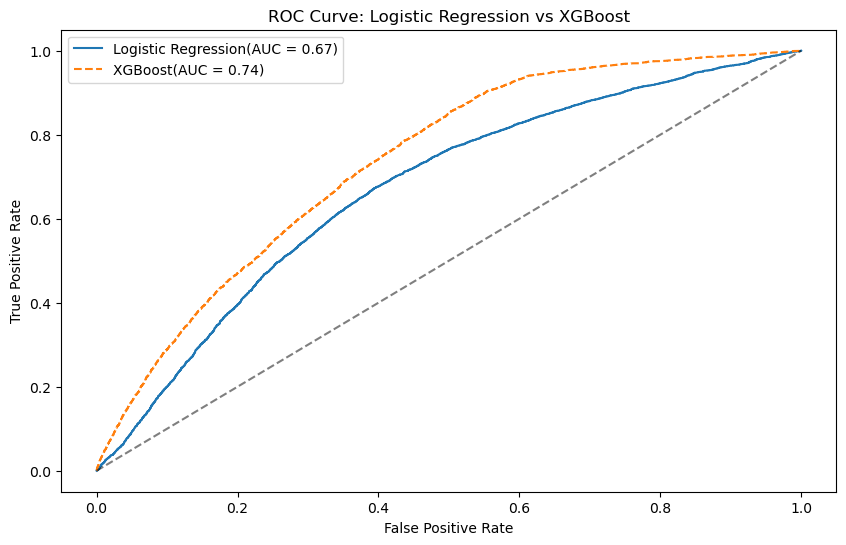

In [239]:
from sklearn.metrics import roc_curve
#Getting false postive and true positive for log regress to compare with xgb
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_prob)
auc_logreg = roc_auc_score(y_test, y_prob)

#Comparing AUC and ROC for xgb
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)

#Plotting ROC Curve
plt.figure(figsize = (10,6))
plt.plot(fpr_logreg, tpr_logreg, label = f'Logistic Regression(AUC = {auc_logreg:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label = f'XGBoost(AUC = {auc_xgb:.2f})', linestyle = '--')
plt.plot([0,1], [0, 1], 'k--', alpha = 0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Logistic Regression vs XGBoost')
plt.legend()
plt.show()

#### Final Comparison Model...Random Forest Classifier!!

In [241]:
#importing random forest classifier from sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

feature_cols = num_cols + dummy_vars #Numberic vals & categorical vals
X = categoric_cols[feature_cols] #Just numerica and cat vars as dep var
y = merge_df['target'] #No_show is target vals
X_train, X_test,y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled [num_cols] = scaler.fit_transform(X_train[num_cols]) #We want to train num vals only
X_test_scaled [ num_cols] = scaler.transform(X_test[num_cols])

### Fitting the Random Forest model and balancing as a precautionary measure and investigating the `Classification Report`.

In the `classification report`, without any tuning, the model correctly identifies actual no-show patients 24% of the time.

In [243]:
#Balancing the model in case there is imbalance
rf_model = RandomForestClassifier(class_weight = 'balanced', random_state = 42)
#Testing and training the dataset
rf_model.fit(X_train, y_train)
#Getting Predictions and probabilities
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

#Getting accuracy_score, confusion_matrix, recall_score, and AUC_score
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_rf))
print('Classification Report:\n',  classification_report(y_test, y_pred_rf))
print('Accuracy Score:\n', accuracy_score(y_test, y_pred_rf))
print('AUC:\n', roc_auc_score(y_test, y_prob_rf))

Confusion Matrix:
 [[15735  1845]
 [ 3441  1083]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86     17580
           1       0.37      0.24      0.29      4524

    accuracy                           0.76     22104
   macro avg       0.60      0.57      0.57     22104
weighted avg       0.73      0.76      0.74     22104

Accuracy Score:
 0.76085776330076
AUC:
 0.7034390720103325


### Comparing the threshold, precision, and F1 score

For F1 score, shows the optiamal threshold that balances the precision and recall score. In this case it appears to be somewhere around 0.4, however the optimal threshold will later be calculated.

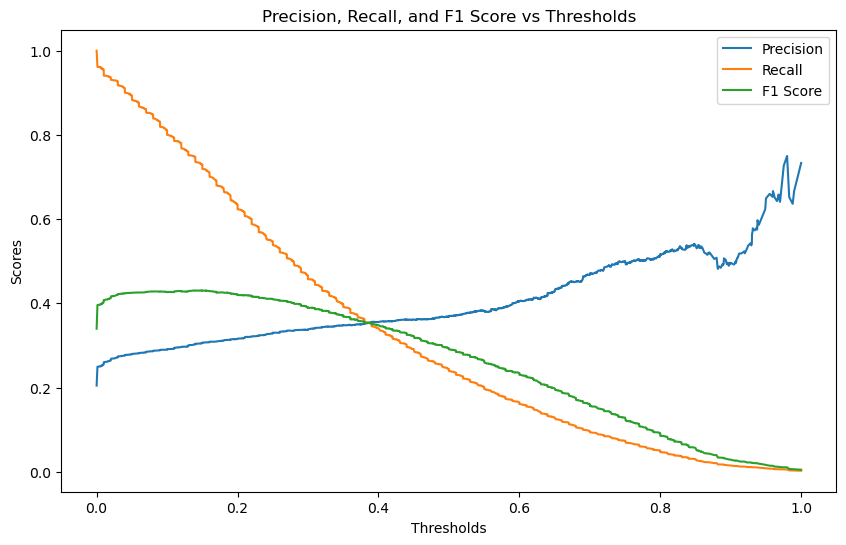

In [200]:
#Doing Threshold Tuning to try to make the model better
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_rf) #Gets the thresholds
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

plt.figure(figsize = (10,6))
plt.plot(thresholds, precision[:-1], label = 'Precision' )
plt.plot(thresholds, recall[:-1], label = 'Recall')
plt.plot(thresholds, f1_scores[:-1], label = 'F1 Score')
plt.xlabel('Thresholds')
plt.ylabel('Scores')
plt.title('Precision, Recall, and F1 Score vs Thresholds')
plt.legend()
plt.show()

### Getting the optimal threshold for `Random Forest` model

Optimal threshold is 0.49

In [227]:
#Getting optimal f1_scores for rf model
optimal_ind = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_ind]
print(f'Optimal Thresholds for Random Forest Classifier: {optimal_threshold:.2f}')

Optimal Thresholds for Random Forest Classifier: 0.49


### Analysing `Classsification Report` after using the optimal threshold
The recall score for no-shows `Class 1` is 0.25, or the model is identifying actual no-shows 25% of the time. This is a significant decrease compared to the Logistic Regression and XGBoost model. In this dataset `Random Forest` is not the best model to use in a business or medical setting.

#Applying threshold tuning to random forest model
y_pred_tuned_rf = (y_prob_rf >= 0.49).astype(int)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_tuned_rf))
print('Classification Report:\n',  classification_report(y_test, y_pred_tuned_rf))
print('Accuracy Score:\n', accuracy_score(y_test, y_pred_tuned_rf))
print('AUC:\n', roc_auc_score(y_test, y_prob_rf))

In [207]:
#Reducing SHAP for plot because it is computationally heavy for RF
#Sampling the test data because SHAP is very computationally expensive
rf_small = RandomForestClassifier(n_estimators = 30, random_state = 42, class_weight = 'balanced')
rf_small.fit(X_train, y_train)
X_test_sample = X_test.sample(n = 50, random_state = 42)
rf_explainer = shap.TreeExplainer(rf_small)
shap_val_rf = rf_explainer.shap_values(X_test_sample)
print(X_test_sample.shape) #Making sure shape is correct
print(np.array(shap_val_rf.shape)) #making sure shape is correct...it is not, slicing needs to be done

(50, 47)
[50 47  2]


#### Due to `shap.TreeExplainer(rf_small, feature_perturbation, model_output = 'raw')` used to be in the visualisation, slicing had to be done in order to make the summary graph run correctly

In [209]:
print(type(shap_val_rf))#Checking to see if it was an array

<class 'numpy.ndarray'>


### Getting the feature importance for `Random Forest`

`Age`, `Days_In_Advanced`, `SMS_received`, and `Gender` are the most important features for this model.

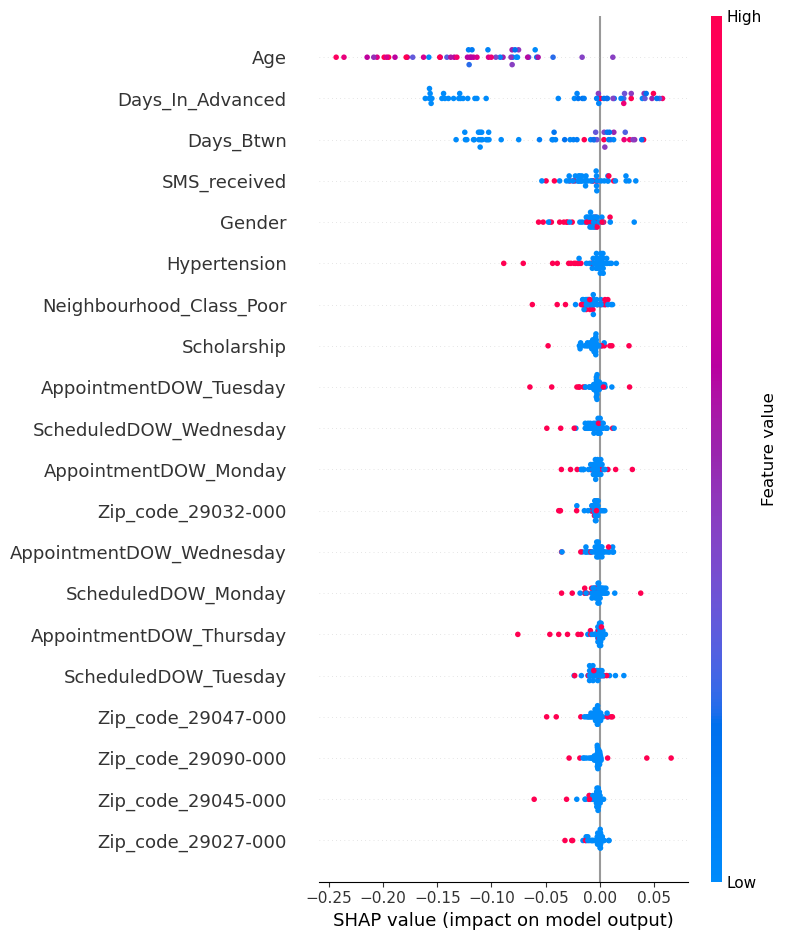

In [210]:
#Summary plot of most important features
shap.summary_plot(shap_val_rf[:, :, 1], X_test_sample)#Slices the 3rd axis to get binary output

### A Better view of the Feature importances

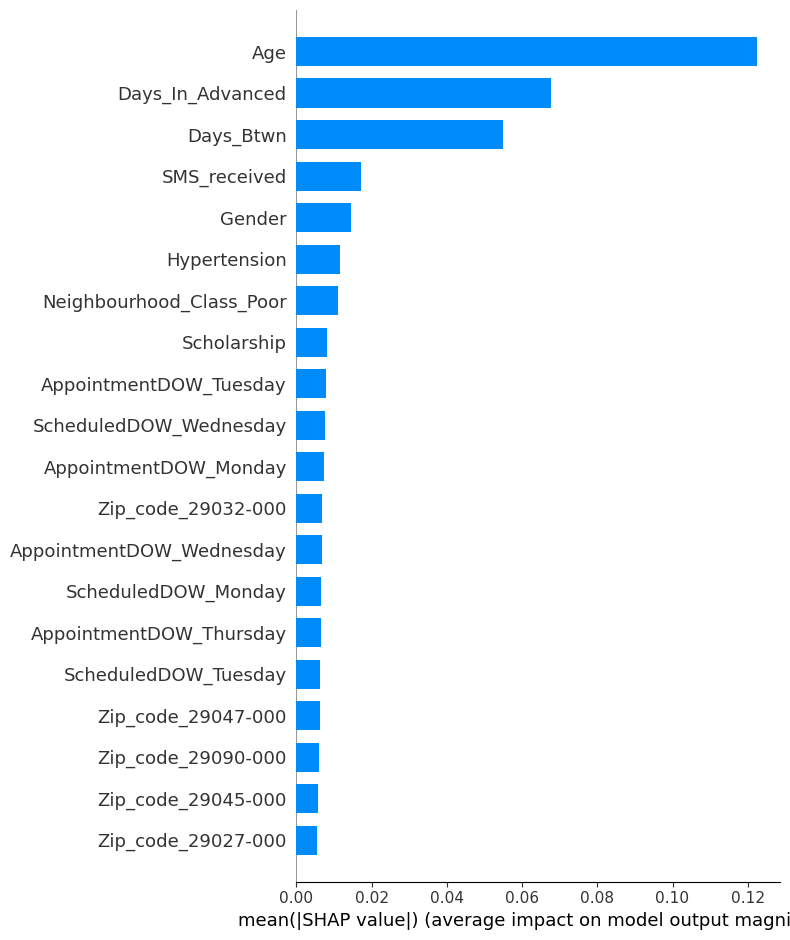

In [214]:
#Getting the feature importance as a bar plot for easier interpretation
shap.summary_plot(shap_val_rf[:, :, 1], X_test_sample, plot_type = 'bar')

In [245]:
#Creating a side-by-side comparison of the different models
log_importance = pd.Series(model.coef_[0], index = X_train.columns)
xgb_importance = pd.Series(xgb_model.feature_importances_, index = X_train.columns)
rf_importance = pd.Series(rf_model.feature_importances_, index = X_train.columns)

model_importances = pd.DataFrame({'Log Regression': log_importance.abs(),
                                 'XGBoost':xgb_importance,
                                 'Random Forest': rf_importance})

#### Retrieving the ROC for Log Reg, XBG, and RF

`XGBoost` outperforms all both the `Logistic Regression` and `Random Forest` model, while the `Random Forest` is slightly better at distinguishing between classes slightly better than `Logistic Regression`, but that is only because of precision score for `Class 0` (patients who are showing up). This could be because `Random Forest` was too aggressive for this dataset so it misclassified a lot of no-patients.

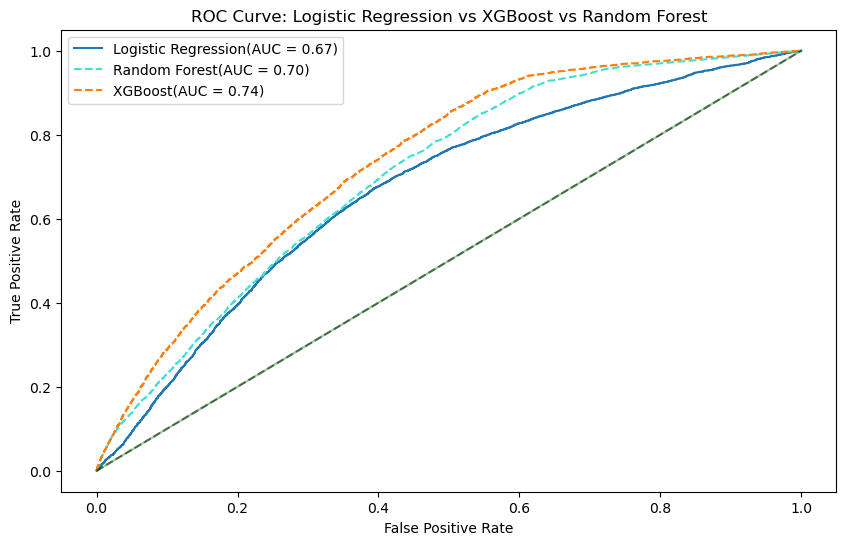

In [247]:
#Getting the false pos and true pos rate
fpr_rf, tpr_rf,_ = roc_curve(y_test, y_prob_rf)
#Gettig the area under the curve (AUC) for RF
auc_rf= roc_auc_score(y_test, y_prob_rf)

#Plotting the different AUC's for comoparison
plt.figure(figsize = (10,6))
plt.plot(fpr_logreg, tpr_logreg, label = f'Logistic Regression(AUC = {auc_logreg:.2f})')
plt.plot(fpr_rf, tpr_rf, label = f'Random Forest(AUC = {auc_rf:.2f})', linestyle = '--', color = 'turquoise')
plt.plot(fpr_xgb, tpr_xgb, label = f'XGBoost(AUC = {auc_xgb:.2f})', linestyle = '--')
plt.plot([0,1], [0, 1], [0,1],'k--', alpha = 0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Logistic Regression vs XGBoost vs Random Forest')
plt.legend()
plt.show()

#### Plotting the top 20 feauture importances for each model side by side

<Figure size 1000x600 with 0 Axes>

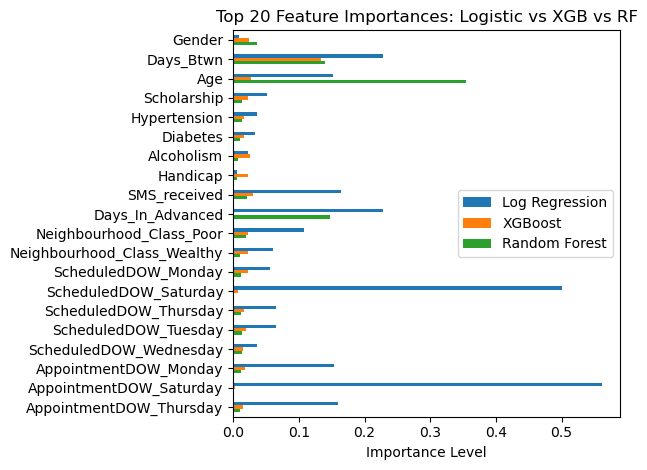

In [255]:
plt.figure(figsize = (10, 6))
model_importances.head(20).plot(kind = 'barh') #Creates a horizontal bar chart
plt.title('Top 20 Feature Importances: Logistic vs XGB vs RF', fontsize = 12)
plt.xlabel ('Importance Level')
plt.gca().invert_yaxis() #plt.gca gets current axes, then the y_axis is inverted
plt.tight_layout()
plt.legend(loc = 'center right', fontsize = 10)
plt.show()

## Conclusion

The XGBoost is a solid model for distinguishing patients who are more likely to be labelled as no-shows. Logistic Regression is a good model to start as a base model and if it does not perform as one would like, then using a more agressive model like the XGBoost or maybe even K-Nearest Neighbours (KNN) would be a model to build upon.

The XGBoost model was able to correctly identify 75% of patients who were most likely to be a no-show. Ways to midigate patients who are more likely to be no-shows could possibly not allow patients to make appointments too far out in advance. This means limitting the days betwen the time a patient scheduled appointment and their actual appointment day. Sending more text reminders could have an effect on reminding patients of their appointment; and possibly making it mandatory to have a guardian come with a patient if they are under ~25 years old or older than ~75-80 years old.

If one wants to use strictly Logistic Regression, then allowing the office to be open on Saturdays could have a huge affect on patient no-shows, as well as limitting the days in advance a patient could make an appointment, sending more text reminders, and possibly making it mandatory to have a guardian come with a patient if they are under ~25 years old or older than ~75-80 years old.

If one chooses to use a Random Forest model, though is not suggested, making a patient have a guardian for the same age ranges as the Logistic Regression and XGBoost, decreasing appointments made in advance, and lowering the days between the days between scheduled and appointment day, could decerase the amount of no-shows tremendously for this Brazillian office.